# 🔻 [Return to workflow](#leftoff)

⚓ ANCHOR FOR RETURN TO WORKFLOW LINK <a name="leftoff"></a>

# **Updates Post Presentation DR:**

* W/ covid neg impact on hospitality/tourism, **increased comp for less tourism**


* **Increased focus on perf** - strongest KPI: customer satisfaction


* **Question/problem/goal:** bring scores up to 4.8+ (superhost rating)
    * **Why SH?** Emphasis on guest experience; see [link](https://www.airbnb.com/help/article/829/how-do-i-become-a-superhost#:~:text=Earning%20Superhost%20status-,Superhost%20requirements,-Completed%20at%20least)    
    * **How:** ID top preds for meeting and missing 4.8+


* **SWOT**
    * **S/W:** EDA step; what is right/wrong right now?
    * **O/T:** Predictors and recommendations

# **New Tasks**

**Tasks:**

- [ ] drop na - across all feats/rows
- [ ] check dist of remaining ratings - histplot
- [ ] convert scores: 0-4.799, 4.8+
- [ ] clean data for eda
- [ ] review feats
- [ ] determine S/W
- [ ] split w/ stratify
- [ ] re-model (macro recall/F1)
- [ ] get results
- [ ] visualize results
- [ ] create recommendations


# 🏡 **“ODD” ASPECTS OF AIRBNB** 🏨

# ❌ Update target audience and guiding questions

---

**Who?**
>* 🏢 **AirBNB Corporate** interested in maximizing customer satisfaction to increase repeat guests and encourage new guests to stay with AirBNB hosts
>
>
>* 🏡**AirBNB hosts** interested in maximizing the ratings

**Why?**
>* 💰 **Revenue Management:** 
>
>
>
>* 🤝 **Sales:**
>
>
>
>* 🛌 **Rooms Ops:**

>
>
>

**What?**
>* 🧾 Dataset comprised of... 
>  * different features
>  * reservation records
>  * Source cited in Readme

❌ **How?**
>* Which models/methods?
>* Data prep and feature engineering

---

# 🎯  **Goal:**

Determining whether or not a host location would receive a score greater than or equal to 4/5 (defined by `'review_scores_rating'`).

# 📂 **Imports and Settings**

In [1]:
## Data Handling
import pandas as pd
import numpy as np
from scipy import stats


## Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact_manual
import missingno

## SKLearn
from sklearn import metrics
from sklearn.preprocessing import Binarizer, MultiLabelBinarizer, \
                                    OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,\
                                    RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
                                AdaBoostClassifier,GradientBoostingClassifier 
from sklearn import set_config
set_config(display='diagram')

from imblearn.over_sampling import SMOTE,SMOTENC


## Settings
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 100)

In [2]:
## Personal functions
import clf_functions.functions as cf

## Tools to reload personal functions when called - prevents errors
%load_ext autoreload
%autoreload 1
%aimport clf_functions.functions

## ✅ Show Visualizations Setting

In [3]:
## Setting to control whether or not to show visualizations
show_visualizations = False

# 📖 **Read Data**

In [4]:
## Reading data and saving to a DataFrame

source = 'data/listings.csv.gz'

data = pd.read_csv(source)

In [5]:
## Inspecting imported dataset
data.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3686,https://www.airbnb.com/rooms/3686,20210710190002,2021-07-11,Vita's Hideaway,IMPORTANT NOTES<br />* Carefully read and be s...,We love that our neighborhood is up and coming...,https://a0.muscache.com/pictures/61e02c7e-3d66...,4645,https://www.airbnb.com/users/show/4645,Vita,2008-11-26,"Washington D.C., District of Columbia, United ...","I am a literary scholar, teacher, poet, vegan ...",within a day,80%,75%,f,https://a0.muscache.com/im/users/4645/profile_...,https://a0.muscache.com/im/users/4645/profile_...,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Washington, District of Columbia, United States",Historic Anacostia,nan,38.86,-76.99,Private room in house,Private room,1,nan,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,nan,t,1,31,61,336,2021-07-11,75,3,0,2014-06-22,2021-01-12,4.59,4.71,4.44,4.89,4.82,3.80,4.58,NaN,f,2,0,2,0,0.87
1,3943,https://www.airbnb.com/rooms/3943,20210710190002,2021-07-11,Historic Rowhouse Near Monuments,Please contact us before booking to make sure ...,This rowhouse is centrally located in the hear...,https://a0.muscache.com/pictures/432713/fab7dd...,5059,https://www.airbnb.com/users/show/5059,Vasa,2008-12-12,"Washington, District of Columbia, United States",I have been living and working in DC for the l...,within a few hours,100%,29%,f,https://a0.muscache.com/im/pictures/user/8ec69...,https://a0.muscache.com/im/pictures/user/8ec69...,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Washington, District of Columbia, United States","Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.00,Private room in townhouse,Private room,2,nan,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",nan,t,9,39,69,344,2021-07-11,429,0,0,2010-08-08,2018-08-07,4.82,4.89,4.91,4.94,4.90,4.54,4.74,NaN,f,2,0,2,0,3.22
2,4529,https://www.airbnb.com/rooms/4529,20210710190002,2021-07-11,Bertina's House Part One,This is large private bedroom with plenty of...,Very quiet neighborhood and it is easy accessi...,https://a0.muscache.com/pictures/86072003/6709...,5803,https://www.airbnb.com/users/show/5803,Bertina'S House,2008-12-30,"Washington, District of Columbia, United States","I am an easy going, laid back person who loves...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/5803/profile_...,https://a0.muscache.com/im/users/5803/profile_...,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Washington, District of Columbia, United States","Eastland Gardens, Kenilworth",nan,38.91,-76.94,Private room

In [6]:
## Checking number of rows and columns
data.shape

(8033, 74)

---

> The initial read of the dataset shows there are 74 features and 8,033 entries. A quick glance at the `.head()` gives a sample of the entries, showing that some of the features are not relevant to my analysis.
>
> I need to get a better idea of the statistics for the dataset, especially any missing values and the datatypes for each column. I need to pre-process this data before I can perform any modeling.

---

# 👨‍💻 **Interactive Investigation**

---

> To increase accessibility to the data, **I include a widget to allow the user to sort through the data interactively.** I use [**Jupyter Widgets**](https://ipywidgets.readthedocs.io/en/latest/index.html) to create this interactive report.
>
>**To use:** select which column by which you would like to sort from the dropdown menu, then click the "Run Interact" button.
>
>***Note about 'Drop_Cols' and Cols:*** these keyword arguments are used to allow the user to drop specific columns.
>
> **Only click the "Drop_Cols" option when specifying "Cols"!** Otherwise it will cause an error.
>
>The 'Cols' dropdown menu does not affect the resulting report; the data is filtered from the report prior to displaying the results. 
>
>I chose to include this option for flexibility and adaptability, but it does have the unintended consequence of creating another drop-down menu. Please ignore this menu, as it does not provide any additional functionality. For future work, I will disable the menu to prevent confusion.

---

In [7]:
## Running report on unfiltered dataset

interact_manual(cf.sort_report, Sort_by=list(cf.report_df(data).columns),
                Source=source);

interactive(children=(Text(value='data/listings.csv.gz', description='Source'), Dropdown(description='Sort_by'…

In [8]:
data.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3686,https://www.airbnb.com/rooms/3686,20210710190002,2021-07-11,Vita's Hideaway,IMPORTANT NOTES<br />* Carefully read and be s...,We love that our neighborhood is up and coming...,https://a0.muscache.com/pictures/61e02c7e-3d66...,4645,https://www.airbnb.com/users/show/4645,Vita,2008-11-26,"Washington D.C., District of Columbia, United ...","I am a literary scholar, teacher, poet, vegan ...",within a day,80%,75%,f,https://a0.muscache.com/im/users/4645/profile_...,https://a0.muscache.com/im/users/4645/profile_...,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Washington, District of Columbia, United States",Historic Anacostia,nan,38.86,-76.99,Private room in house,Private room,1,nan,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,nan,t,1,31,61,336,2021-07-11,75,3,0,2014-06-22,2021-01-12,4.59,4.71,4.44,4.89,4.82,3.80,4.58,NaN,f,2,0,2,0,0.87
1,3943,https://www.airbnb.com/rooms/3943,20210710190002,2021-07-11,Historic Rowhouse Near Monuments,Please contact us before booking to make sure ...,This rowhouse is centrally located in the hear...,https://a0.muscache.com/pictures/432713/fab7dd...,5059,https://www.airbnb.com/users/show/5059,Vasa,2008-12-12,"Washington, District of Columbia, United States",I have been living and working in DC for the l...,within a few hours,100%,29%,f,https://a0.muscache.com/im/pictures/user/8ec69...,https://a0.muscache.com/im/pictures/user/8ec69...,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Washington, District of Columbia, United States","Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.00,Private room in townhouse,Private room,2,nan,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",nan,t,9,39,69,344,2021-07-11,429,0,0,2010-08-08,2018-08-07,4.82,4.89,4.91,4.94,4.90,4.54,4.74,NaN,f,2,0,2,0,3.22
2,4529,https://www.airbnb.com/rooms/4529,20210710190002,2021-07-11,Bertina's House Part One,This is large private bedroom with plenty of...,Very quiet neighborhood and it is easy accessi...,https://a0.muscache.com/pictures/86072003/6709...,5803,https://www.airbnb.com/users/show/5803,Bertina'S House,2008-12-30,"Washington, District of Columbia, United States","I am an easy going, laid back person who loves...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/5803/profile_...,https://a0.muscache.com/im/users/5803/profile_...,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Washington, District of Columbia, United States","Eastland Gardens, Kenilworth",nan,38.91,-76.94,Private room

---

> After reviewing my data, I see there are several features that contain irrelevant entries (URLs, source data, meta data) or values that are too complicated for simple processing (such as host and listing descriptions).
>
> I will drop these columns for the second report to review the remaining data for further processing.

---

In [9]:
## Specifying columns to drop

drop = ['id', 'host_id', 'name', 'description', 'neighborhood_overview', 'host_name',
        'host_about', 'host_location', 'neighbourhood', 'property_type',
        'listing_url', 'scrape_id', 'last_scraped', 'picture_url','host_url',
        'host_thumbnail_url','host_picture_url','calendar_last_scraped']

In [10]:
## Creating updated interactive report

interact_manual(cf.sort_report, Drop_Cols = True, Cols = drop,
                Sort_by=list(cf.report_df(data).columns), Source=source);

interactive(children=(Text(value='data/listings.csv.gz', description='Source'), Dropdown(description='Sort_by'…

---

> **Interpretation:**
>
> The report shows that the dataset has a big problem with missing values:
>
> * **Empty:**
>   * `neighbourhood_group_cleansed`
>   * `bathrooms`
>   * `calendar_updated`
>
>
> * **Nearly empty:**
>  * `license`
>
>
> * **Missing 26-39% of data:**
>  * `host_about`
>  * `neighborhood_overview`
>  * `neighbourhood`
>  * `host_response_time`
>  * `host_response_rate`
>  * `review_scores_value`
>  * `review_scores_checkin`
>  * `review_scores_location`
>  * `review_scores_accuracy`
>  * `review_scores_communication`
>  * `review_scores_cleanliness`
>  * `host_acceptance_rate`
>  * `reviews_per_month`
>  * `first_review`
>  * `review_scores_rating`
>  * `last_review`
>
>---
>
> I will need to address these missing values before processing with the modeling. A few options include:
>
> * **Filling with the string "missing"** to indicate the value was missing.
>    * *I would be able to treat "missing" as a distinct category and use it for modeling as well.*
>
>
> * **Dropping the rows with missing values.**
>    * *This may negatively impact the accuracy of my results by overfitting to the training data.*
>
>
> * I could **use the `SimpleImputer` tool from SKLearn to fill the missing values** with the mean, median, or mode values for each.
>    * *I could couple this with a `GridSearchCV` to identify the method that has the strongest positive impact on my classification metrics.*

---

---

> To get a better idea of the missing values, I create a visual of the values via the 'Missingno' package. This visualization package includes several options for visualizing the missing data.

---

In [11]:
## Visually inspecting missing values
if show_visualizations == True:
    missingno.bar(data, labels=True);

---

> Based on this visualization, I see that **there is a consistent trend in missing values for review scores:** if a row is missing one review score, it seems to be missing all of them.
>
> Additionally, **there are many missing values for the response time, response rate, and acceptance rate.** I want to use these columns in my classification, so I will need to replace those missing values.
>
> After reviewing these details, **I feel more comfortable with the option of dropping those rows with missing review values.** I will drop the values as part of my overall classification process.

---

# 🧼 **Data Cleaning and EDA**

## 🔎 Fixing Missing Values

---

> This dataset is missing a significant number of values for different columns. **In order to perform any modeling, I will address these missing values first.**
>
> Depending on the feature and the number of missing values per row, I take different approaches to keep as much data as possible and in its original state.

---

In [12]:
# Dropping features with high percentages (25%+) of missing values

drop_na_cols = []
for col in data.columns:
    if ((data[col].isna().sum()) / len(data[col])) > .25 and col != 'review_scores_rating':
        drop_na_cols.append(col)

drop_na_cols

['neighborhood_overview',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'bathrooms',
 'calendar_updated',
 'first_review',
 'last_review',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'reviews_per_month']

In [13]:
## Appending previous list of columns to drop (metadata, etc.)

for col in drop:
    if col not in drop_na_cols:
        drop_na_cols.append(col)

drop_na_cols

['neighborhood_overview',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'bathrooms',
 'calendar_updated',
 'first_review',
 'last_review',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'reviews_per_month',
 'id',
 'host_id',
 'name',
 'description',
 'host_name',
 'host_location',
 'property_type',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url',
 'calendar_last_scraped']

In [14]:
## Creating new dataframe that does not include the features to drop
df = data.drop(columns= drop_na_cols).copy()
df

,host_since,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2008-11-26,f,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,38.86,-76.99,Private room,1,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,t,1,31,61,336,75,3,0,4.59,f,2,0,2,0
1,2008-12-12,f,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.00,Private room,2,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",t,9,39,69,344,429,0,0,4.82,f,2,0,2,0
2,2008-12-30,f,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",38.91,-76.94,Private room,4,1 shared bath,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Keypad"", ...",$54.00,30,180,30,30,180,180,30.00,180.00,t,29,59,89,179,102,0,0,4.66,f,1,0,1,0
3,2009-01-26,t,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.99,Private room,1,3 baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",$99.00,2,365,2,2,365,365,2.00,365.00,t,0,0,0,146,31,0,0,4.74,f,3,0,3,0
4,2009-01-13,f,Adams Morgan,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Entire home/apt,3,1 bath,1.00,1.00,"[""Window guards"", ""Cooking basics"", ""First aid...",$86.00,5,150,5,23,150,150,8.80,150.00,t,7,32,62,121,95,0,0,4.54,f,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8028,2020-08-03,f,Southeast Washington,0.00,0.00,"['email', 'phone']",t,f,"Congress Heights, Bellevue, Washington Highlands",38.83,-77.00,Entire home/apt,8,1 bath,3.00,3.00,"[""First aid kit"", ""Dedicated workspace"", ""Smok...",$400.00,2,2,2,2,1125,1125,2.00,"1,125.00",t,17,43,73,348,0,0,0,nan,t,1,1,0,0
8029,2020-07-29,f,East Forest,125.00,125.00,"['email', 'phone']",t,t,"Howard University, Le Droit Park, Cardozo/Shaw",38.92,-77.02,Entire home/apt,5,2 baths,2.00,nan,"[""Cooking basics"", ""Lockbox"", ""Long term stays...",$198.00,90,365,90,90,365,365,90.00,365.00,t,30,60,90,365,0,0,0,nan,t,215,215,0,0
8030,2016-04-27,f,Near Northeast/H Street Corridor,32.00,32.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Entire home/apt,2,1 bath,1.00,2.00,"[""Cooking basics"", ""Shampoo"", ""Dedicated works...",$70.00,30,1125,30,30,1125,1125,30.00,"1,125.00",t,30,60,90,364,0,0,0,nan,f,30,30,0,0
8031,2020-09-23,f,Cherry Creek,"2,232.00","2,232.00","['email', 'phone']",t,t,"Shaw, Logan Circle",38.91,-77.03,Entire home/apt,3,1 bath,1.00,nan,"[""Cooking basics"", ""Elevator"", ""Lockbox"", ""Lon...",$223.00,91,365,91,91,365,365,91.00,365.00,t,30,60,90,365,0,0,0,nan,t,50,50,0,0


In [15]:
## Inspecting values prior to dropping
cf.report_df(df)

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
host_since,136,0.02,object,2415,nan,nan,nan,nan,nan,nan,nan,nan
host_is_superhost,136,0.02,object,2,nan,nan,nan,nan,nan,nan,nan,nan
host_neighbourhood,741,0.09,object,183,nan,nan,nan,nan,nan,nan,nan,nan
host_listings_count,136,0.02,float64,57,"7,897.00",86.19,334.72,0.00,1.00,2.00,6.00,"3,924.00"
host_total_listings_count,136,0.02,float64,57,"7,897.00",86.19,334.72,0.00,1.00,2.00,6.00,"3,924.00"
host_verifications,0,0.00,object,297,nan,nan,nan,nan,nan,nan,nan,nan
host_has_profile_pic,136,0.02,object,2,nan,nan,nan,nan,nan,nan,nan,nan
host_identity_verified,136,0.02,object,2,nan,nan,nan,nan,nan,nan,nan,nan
neighbourhood_cleansed,0,0.00,object,39,nan,nan,nan,nan,nan,nan,nan,nan
latitude,0,0.00,float64,5113,"8,033.00",38.91,0.02,38.82,38.90,38.91,38.92,39.00


## Dropping Rows Without Target Value

In [16]:
## Checking for rows missing target values

nan_index = df['review_scores_rating'].isna()
nan_index

0       False
1       False
2       False
3       False
4       False
        ...  
8028     True
8029     True
8030     True
8031     True
8032     True
Name: review_scores_rating, Length: 8033, dtype: bool

In [17]:
## Inspecting rows to be dropped for missing the target feature
df[nan_index][:5]

,host_since,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
40,2011-07-22,f,Manor Park,2.00,2.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Takoma, Brightwood, Manor Park",38.96,-77.02,Private room,1,1.5 shared baths,1.00,4.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",$399.00,1,730,1,1,730,730,1.00,730.00,t,30,60,90,365,0,0,0,nan,f,2,1,1,0
70,2012-01-25,f,Near Northeast,2.00,2.00,"['email', 'phone']",t,f,"Union Station, Stanton Park, Kingman Park",38.90,-77.00,Entire home/apt,4,2 baths,2.00,2.00,"[""Refrigerator"", ""Long term stays allowed"", ""C...",$125.00,5,1125,5,5,1125,1125,5.00,"1,125.00",t,17,38,68,343,0,0,0,nan,f,2,2,0,0
80,2012-04-24,f,Logan Circle,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Downtown, Chinatown, Penn Quarters, Mount Vern...",38.91,-77.03,Entire home/apt,1,1.5 baths,1.00,1.00,"[""Elevator"", ""Cable TV"", ""TV with standard cab...",$99.00,150,1125,150,150,1125,1125,150.00,"1,125.00",t,29,59,89,364,0,0,0,nan,f,1,1,0,0
120,2009-11-26,f,Capitol Hill,1.00,1.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Capitol Hill, Lincoln Park",38.89,-76.99,Entire home/apt,6,NaN,3.00,nan,[],"$2,000.00",4,4,4,4,4,4,4.00,4.00,t,30,60,90,365,0,0,0,nan,f,1,1,0,0
145,2013-04-24,f,Adams Morgan,1.00,1.00,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Entire home/apt,2,2 baths,2.00,2.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",$120.00,180,180,180,180,180,180,180.00,180.00,f,0,0,0,0,0,0,0,nan,f,1,1,0,0


In [18]:
## Dropping rows from main dataframe
df.drop(df[nan_index].index, inplace=True)

In [19]:
## Reviewing results

cf.report_df(df)

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
host_since,10,0.00,object,2164,nan,nan,nan,nan,nan,nan,nan,nan
host_is_superhost,10,0.00,object,2,nan,nan,nan,nan,nan,nan,nan,nan
host_neighbourhood,488,0.08,object,169,nan,nan,nan,nan,nan,nan,nan,nan
host_listings_count,10,0.00,float64,48,"5,816.00",43.93,206.60,0.00,1.00,2.00,4.00,"1,683.00"
host_total_listings_count,10,0.00,float64,48,"5,816.00",43.93,206.60,0.00,1.00,2.00,4.00,"1,683.00"
host_verifications,0,0.00,object,269,nan,nan,nan,nan,nan,nan,nan,nan
host_has_profile_pic,10,0.00,object,2,nan,nan,nan,nan,nan,nan,nan,nan
host_identity_verified,10,0.00,object,2,nan,nan,nan,nan,nan,nan,nan,nan
neighbourhood_cleansed,0,0.00,object,39,nan,nan,nan,nan,nan,nan,nan,nan
latitude,0,0.00,float64,4077,"5,826.00",38.91,0.02,38.82,38.90,38.91,38.92,38.99


## Filling Beds

---

> After dropping columns and rows with large percentages of missing values, I proceed to address the missing values in the 'Beds' and "Bedrooms" columns.
>
> As the values are similar between the two, I will compare the rows against each other. For each row, if there is a missing value in one column that is present in the other, I will fill the missing value with the value present in the other column.

---

In [20]:
## Filling missing values for 'beds' with values for 'bedrooms'

for idx in list(df['beds'][df['beds'].isna()].index):
    if df['bedrooms'][idx] > 0:
        df['beds'][idx] = df['bedrooms'][idx]

<ipython-input-20-736ac37997da>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['beds'][idx] = df['bedrooms'][idx]


In [21]:
## Filling missing values for 'bedrooms' with values for 'beds'

for idx in list(df['bedrooms'][df['bedrooms'].isna()].index):
    if df['beds'][idx] > 0:
        df['bedrooms'][idx] = df['beds'][idx]

<ipython-input-21-ae0f6b239e0a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bedrooms'][idx] = df['beds'][idx]


In [22]:
## Resetting the index after dropping rows

df.reset_index(drop=True, inplace=True)

In [23]:
## Confirming reduction in missing values for 'beds' and 'bedrooms'

rpt_clean  = cf.report_df(df)
rpt_clean[rpt_clean['null_sum'] >0]

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
host_since,10,0.00,object,2164,nan,nan,nan,nan,nan,nan,nan,nan
host_is_superhost,10,0.00,object,2,nan,nan,nan,nan,nan,nan,nan,nan
host_neighbourhood,488,0.08,object,169,nan,nan,nan,nan,nan,nan,nan,nan
host_listings_count,10,0.00,float64,48,"5,816.00",43.93,206.60,0.00,1.00,2.00,4.00,"1,683.00"
host_total_listings_count,10,0.00,float64,48,"5,816.00",43.93,206.60,0.00,1.00,2.00,4.00,"1,683.00"
host_has_profile_pic,10,0.00,object,2,nan,nan,nan,nan,nan,nan,nan,nan
host_identity_verified,10,0.00,object,2,nan,nan,nan,nan,nan,nan,nan,nan
bathrooms_text,4,0.00,object,25,nan,nan,nan,nan,nan,nan,nan,nan
bedrooms,71,0.01,float64,9,"5,755.00",1.51,0.90,1.00,1.00,1.00,2.00,9.00
beds,1,0.00,float64,16,"5,825.00",1.90,1.44,0.00,1.00,1.00,2.00,19.00


In [24]:
## Identifying index for remaining missing row for "beds"

nan_bed = list(df['beds'][df['beds'].isna() > 0].index)
nan_bed

[4782]

In [25]:
## Inspecting row with missing value for "bed"
df.iloc[nan_bed]

,host_since,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
4782,2019-08-22,f,U Street Corridor,0.00,0.00,"['email', 'phone']",t,t,"Howard University, Le Droit Park, Cardozo/Shaw",38.92,-77.03,Hotel room,0,NaN,nan,nan,"[""Bed sheets and pillows"", ""First aid kit"", ""O...",$0.00,1,365,1,1,365,365,1.00,365.00,t,0,0,0,0,33,19,7,4.36,f,3,0,0,2


---

> After cleaning the 'bed'/'bedroom' columns, I see that I have one remaining missing pair of columns in one row. Later on, I will fill that value with an imputer as part of my modeling pipeline process.

---

## Dropping Rows with 6+ Missing Values

In [26]:
## Removing rows with 6+ null values

df = df[df.isna().sum(axis=1) < 6]
df.head(5)

,host_since,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2008-11-26,f,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,38.86,-76.99,Private room,1,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,t,1,31,61,336,75,3,0,4.59,f,2,0,2,0
1,2008-12-12,f,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.00,Private room,2,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",t,9,39,69,344,429,0,0,4.82,f,2,0,2,0
2,2008-12-30,f,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",38.91,-76.94,Private room,4,1 shared bath,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Keypad"", ...",$54.00,30,180,30,30,180,180,30.00,180.00,t,29,59,89,179,102,0,0,4.66,f,1,0,1,0
3,2009-01-26,t,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.99,Private room,1,3 baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",$99.00,2,365,2,2,365,365,2.00,365.00,t,0,0,0,146,31,0,0,4.74,f,3,0,3,0
4,2009-01-13,f,Adams Morgan,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Entire home/apt,3,1 bath,1.00,1.00,"[""Window guards"", ""Cooking basics"", ""First aid...",$86.00,5,150,5,23,150,150,8.80,150.00,t,7,32,62,121,95,0,0,4.54,f,2,1,1,0


In [27]:
## Reviewing remaining missing values

df.isna().sum()[df.isna().sum() > 0]

host_neighbourhood    478
bathrooms_text          4
bedrooms               71
beds                    1
dtype: int64

---

> 

---

In [28]:
cf.report_df(df)

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
host_since,0,0.00,object,2164,nan,nan,nan,nan,nan,nan,nan,nan
host_is_superhost,0,0.00,object,2,nan,nan,nan,nan,nan,nan,nan,nan
host_neighbourhood,478,0.08,object,169,nan,nan,nan,nan,nan,nan,nan,nan
host_listings_count,0,0.00,float64,48,"5,816.00",43.93,206.60,0.00,1.00,2.00,4.00,"1,683.00"
host_total_listings_count,0,0.00,float64,48,"5,816.00",43.93,206.60,0.00,1.00,2.00,4.00,"1,683.00"
host_verifications,0,0.00,object,268,nan,nan,nan,nan,nan,nan,nan,nan
host_has_profile_pic,0,0.00,object,2,nan,nan,nan,nan,nan,nan,nan,nan
host_identity_verified,0,0.00,object,2,nan,nan,nan,nan,nan,nan,nan,nan
neighbourhood_cleansed,0,0.00,object,39,nan,nan,nan,nan,nan,nan,nan,nan
latitude,0,0.00,float64,4073,"5,816.00",38.91,0.02,38.82,38.90,38.91,38.92,38.99


In [29]:
## Resetting the index after dropping rows

df.reset_index(drop=True, inplace=True)

# 🎯 **Inspecting Review Ratings**

---

> Now that I dropped most of my missing values, I review the distribution of my ratings.
>
> **My main focus is to review the split of values at the 4.8 mark.** This split will give me an idea of the performance of the host properties in my data set.

---


In [30]:
## Reviewing the total ratings at or above the threshold of 4.8

len(df['review_scores_rating'][df['review_scores_rating'] >= 4.8])/ len(df)

0.6196698762035764

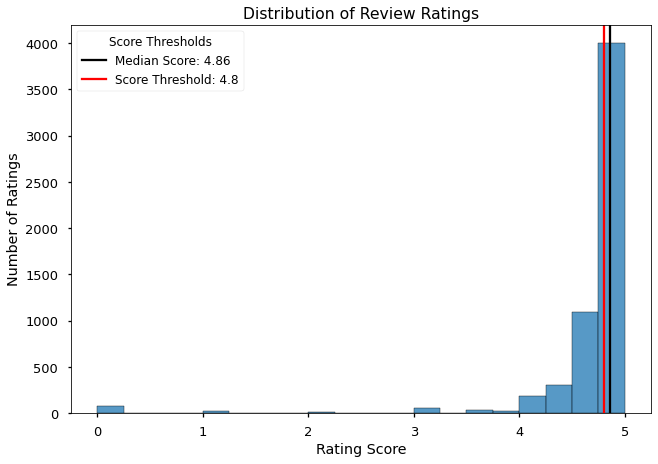

In [31]:
## Visualizing the overall distribution of ratings

ax = sns.histplot(data = data['review_scores_rating'], bins = 20)

ax.set(title = 'Distribution of Review Ratings',
       xlabel = 'Rating Score', ylabel = 'Number of Ratings')

median = df['review_scores_rating'].median()

ax.axvline(median, label = f'Median Score: {median}', color='k')

ax.axvline(4.8, label = 'Score Threshold: 4.8', color='red')

ax.legend(fontsize= 'large',title = 'Score Thresholds',
          title_fontsize = 'large');

---

> Based on the results above, I see that **59% of the reviews are at or below our target threshold of 4.8.**
>
> These scores show that there's a reasonable balance of scores that are meeting our threshold for being a Superhost vs. those that are not. This balance is very important for the modeling process later in my workflow.

---

In [32]:
len(df['review_scores_rating'][df['review_scores_rating'] >= 4.8])/ len(df)

0.6196698762035764

# 🔨 **Formatting Features**

---

> Now that I addressed most of my missing values, I process the remaining features and columns to allow for the modeling process.
>
> I perform the following changes:
>* Any **features with 't'/'f' values** need to be **converted to 1/0**, respectively.
>
>
>* The "price" feature is currently a string value; in order to use it effectively, I will **convert the values to the float datatype**.
>
>
>* **Creating a new feature, "Years_Hosting,"** using the year in which the host started in the "host_since" feature.
>
>
>* **Converting "bathrooms_text" into a new "num_bathrooms" feature** with numeric data.
>* **Cleaning the "room_type"** column values into simpler string values.
>
>
>* The 'neighbourhood_cleansed' feature consists of a single string of neighborhoods. I **separate each neighborhood into a standalone binary feature** for each row.

---

## Converting True/False Columns to Binary Values

In [33]:
## Creating list of true/false features to convert to 1/0, respectively

t_f_xf = ['host_is_superhost','host_has_profile_pic','host_identity_verified',
          'has_availability','instant_bookable']
t_f_xf

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'has_availability',
 'instant_bookable']

In [34]:
## Converting datatype to "string" to replace values

df.loc[:,t_f_xf] = df.loc[:,t_f_xf].astype('str')
df[t_f_xf].dtypes

C:\Users\bmcca\anaconda3\envs\learn-env-bmc\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


host_is_superhost         object
host_has_profile_pic      object
host_identity_verified    object
has_availability          object
instant_bookable          object
dtype: object

In [35]:
df[t_f_xf][:5]

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
0,f,t,t,t,f
1,f,t,t,t,f
2,f,t,t,t,f
3,t,t,t,t,f
4,f,t,t,t,f


In [36]:
## Converting t/f to 1/0, respectively

df.loc[:,t_f_xf] = df.loc[:,t_f_xf].replace({ 't' : 1, 'f' : 0})

C:\Users\bmcca\anaconda3\envs\learn-env-bmc\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [37]:
df[t_f_xf][:5]

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
0,0,1,1,1,0
1,0,1,1,1,0
2,0,1,1,1,0
3,1,1,1,1,0
4,0,1,1,1,0


In [38]:
df.loc[:,t_f_xf] = df.loc[:,t_f_xf].astype(int)

C:\Users\bmcca\anaconda3\envs\learn-env-bmc\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [39]:
## Verifying results

cf.report_df(df[t_f_xf])

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
host_is_superhost,0,0.00,int32,2,"5,816.00",0.33,0.47,0.00,0.00,0.00,1.00,1.00
host_has_profile_pic,0,0.00,int32,2,"5,816.00",1.00,0.03,0.00,1.00,1.00,1.00,1.00
host_identity_verified,0,0.00,int32,2,"5,816.00",0.82,0.39,0.00,1.00,1.00,1.00,1.00
has_availability,0,0.00,int32,2,"5,816.00",0.98,0.14,0.00,1.00,1.00,1.00,1.00
instant_bookable,0,0.00,int32,2,"5,816.00",0.37,0.48,0.00,0.00,0.00,1.00,1.00


## Converting Price to Float 

In [40]:
## Converting each value into a float for processing

df['price'] = df['price'].map(lambda price: price[1:].replace(',','')).astype('float')
df['price'][0]

<ipython-input-40-64fcc6d81799>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].map(lambda price: price[1:].replace(',','')).astype('float')


55.0

In [41]:
df['price'].describe()

count    5,816.00
mean       149.96
std        225.75
min          0.00
25%         77.00
50%        108.00
75%        163.00
max     10,000.00
Name: price, dtype: float64

## Creating "Years_Hosting"

---

> Since the 'host_since' feature is clearly a date, I will create a separate feature for how many years of activity for each host.

---

In [42]:
df['years_hosting'] = df["host_since"].map(lambda x: 2021- int(x.split("-")[0]))
df['years_hosting']

<ipython-input-42-111cfbd782bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['years_hosting'] = df["host_since"].map(lambda x: 2021- int(x.split("-")[0]))


0       13
1       13
2       13
3       12
4       12
        ..
5811     7
5812     9
5813    10
5814     2
5815     2
Name: years_hosting, Length: 5816, dtype: int64

In [43]:
df['years_hosting'].value_counts()

6     1226
5      961
7      803
8      641
4      492
9      379
3      351
2      292
10     227
0      142
1      138
11      79
12      66
13      19
Name: years_hosting, dtype: int64

In [44]:
df['years_hosting'].describe()

count   5,816.00
mean        5.89
std         2.45
min         0.00
25%         5.00
50%         6.00
75%         7.00
max        13.00
Name: years_hosting, dtype: float64

---

> I successfully created the new feature to represent how long each host is active (up to 2021). I will be curious to see the impact of the years of experience on the overall rating at the end of my modeling process.

---

## Bathrooms_Text to Num_Bathrooms

---

> In the raw data, the original "bathrooms" feature was empty and was dropped as part of processing missing data.
>
> **My goal is to convert the "bathrooms_text" feature into a new "num_bathrooms" feature to indicate the number of bathrooms at a host property.**
>
> I assume the number of bathrooms would have an impact on the rating . More bathrooms could mean more space/comfort for the guest, but could also cause an increase in price.


---

In [45]:
## Checking current dataframe contents
df.head(3)

,host_since,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,years_hosting
0,2008-11-26,0,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",1,1,Historic Anacostia,38.86,-76.99,Private room,1,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",55.00,2,365,2,2,365,365,2.00,365.00,1,1,31,61,336,75,3,0,4.59,0,2,0,2,0,13
1,2008-12-12,0,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",1,1,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.00,Private room,2,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",1,9,39,69,344,429,0,0,4.82,0,2,0,2,0,13
2,2008-12-30,0,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",1,1,"Eastland Gardens, Kenilworth",38.91,-76.94,Private room,4,1 shared bath,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Keypad"", ...",54.00,30,180,30,30,180,180,30.00,180.00,1,29,59,89,179,102,0,0,4.66,0,1,0,1,0,13


In [46]:
## Checking for missing values overall
df.isna().sum()[df.isna().sum() > 0]

host_neighbourhood    478
bathrooms_text          4
bedrooms               71
beds                    1
dtype: int64

In [47]:
## Inspecting a selection of values from the column to understand the values
df.loc[:,'bathrooms_text'][:21]

0       1 private bath
1     1.5 shared baths
2        1 shared bath
3              3 baths
4               1 bath
5               1 bath
6        1 shared bath
7               1 bath
8               1 bath
9     1.5 shared baths
10              1 bath
11    1.5 shared baths
12      1 private bath
13              1 bath
14    1.5 shared baths
15      1 private bath
16       1 shared bath
17           2.5 baths
18      1 private bath
19              1 bath
20                 NaN
Name: bathrooms_text, dtype: object

In [48]:
## Inspecting the rows in which there are null values
df[df['bathrooms_text'].isna()]

,host_since,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,years_hosting
20,2010-10-04,1,Logan Circle,1.00,1.00,"['email', 'phone', 'facebook', 'reviews']",1,0,"Dupont Circle, Connecticut Avenue/K Street",38.91,-77.03,Entire home/apt,2,NaN,1.00,1.00,"[""Cooking basics"", ""Lockbox"", ""Dedicated works...",195.00,3,365,3,3,365,365,3.00,365.00,1,17,47,77,352,156,2,0,4.85,0,1,1,0,0,11
25,2009-01-26,1,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1,1,"Ivy City, Arboretum, Trinidad, Carver Langston",38.90,-76.99,Private room,1,NaN,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",99.00,2,730,2,2,730,730,2.00,730.00,1,4,13,18,197,10,0,0,4.89,0,3,0,3,0,12
26,2009-01-26,1,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1,1,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.98,Private room,1,NaN,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",99.00,2,730,2,2,730,730,2.00,730.00,1,1,14,20,198,10,0,0,4.90,0,3,0,3,0,12
4782,2019-08-22,0,U Street Corridor,0.00,0.00,"['email', 'phone']",1,1,"Howard University, Le Droit Park, Cardozo/Shaw",38.92,-77.03,Hotel room,0,NaN,nan,nan,"[""Bed sheets and pillows"", ""First aid kit"", ""O...",0.00,1,365,1,1,365,365,1.00,365.00,1,0,0,0,0,33,19,7,4.36,0,3,0,0,2,2


In [49]:
## Filling null values with unique string ('Baths' not present otherwise)
## Unique string can be used later to check for any other zero baths

df.loc[:,'bathrooms_text'].fillna('0 Baths', inplace=True)

C:\Users\bmcca\anaconda3\envs\learn-env-bmc\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [50]:
## Verifying all null values are filled
df.isna().sum()[df.isna().sum() > 0]

host_neighbourhood    478
bedrooms               71
beds                    1
dtype: int64

In [51]:
df.loc[:,'bathrooms_text'].isna().sum()

0

In [52]:
## Splitting each list into separate strings
df['num_bathrooms'] = df['bathrooms_text'].map(lambda x: x.split(' ')[0])
df['num_bathrooms'].value_counts()

<ipython-input-52-926c4f5fca7a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_bathrooms'] = df['bathrooms_text'].map(lambda x: x.split(' ')[0])


1            4180
2             565
1.5           464
2.5           330
3.5           106
3              91
4              30
4.5            20
0              14
5.5             5
5               3
11              2
6.5             2
6               2
Half-bath       1
Shared          1
Name: num_bathrooms, dtype: int64

In [53]:
## Inspecting results that are phrases, not numbers

replace = ['Half-bath', 'Shared', 'Private']

for x in df['bathrooms_text']:
    for i in replace:
        if i in x:
            print(x)

Shared half-bath
Half-bath


---

> **I will replace these values with the numeric value .5 as they are half-baths.** This will allow me to convert the column datatype to a float and use the column more easily in my modeling.

---

In [54]:
## Replacing string values with .5 to represent half-bathrooms

replace = {'Half-bath': .5, 'Shared': .5, 'Private': .5}

df['num_bathrooms'].replace(replace, inplace = True)

df['num_bathrooms'] = df['num_bathrooms'].astype(float)

C:\Users\bmcca\anaconda3\envs\learn-env-bmc\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-54-36f8771ec030>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_bathrooms'] = df['num_bathrooms'].astype(float)


In [55]:
## Inspecting resulting values

df['num_bathrooms'].value_counts(dropna=False)

1.00     4180
2.00      565
1.50      464
2.50      330
3.50      106
3.00       91
4.00       30
4.50       20
0.00       14
5.50        5
5.00        3
6.50        2
0.50        2
11.00       2
6.00        2
Name: num_bathrooms, dtype: int64

In [56]:
## Inspecting listings with more than 10 rooms

df[df['num_bathrooms'] >10]

,host_since,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,years_hosting,num_bathrooms
1271,2016-01-31,0,Adams Morgan,7.00,7.00,"['email', 'phone', 'reviews']",1,0,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Shared room,1,11 shared baths,1.00,6.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",47.00,1,31,13,13,91,91,13.00,91.00,1,0,0,0,0,7,1,0,4.86,1,3,0,1,2,5,11.00
5039,2016-01-31,0,Adams Morgan,7.00,7.00,"['email', 'phone', 'reviews']",1,0,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Shared room,1,11 shared baths,1.00,3.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",47.00,7,180,13,13,91,91,13.00,91.00,1,0,0,0,0,6,6,0,4.17,1,3,0,1,2,5,11.00


---

> After taking a look at the locations listed above on Google Maps (using their latitude/longitude), I feel like these three listings with more than 10 bathrooms are either duplicates or incorrect values (for 50 baths).
>
> Due to the questionable nature of these values, I will drop these rows to prevent these outliers from impacting my results.

---

In [57]:
## Inspecting rows where 'num_bathrooms' is zero to validate data

df[df['num_bathrooms'] ==0]

,host_since,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,years_hosting,num_bathrooms
20,2010-10-04,1,Logan Circle,1.00,1.00,"['email', 'phone', 'facebook', 'reviews']",1,0,"Dupont Circle, Connecticut Avenue/K Street",38.91,-77.03,Entire home/apt,2,0 Baths,1.00,1.00,"[""Cooking basics"", ""Lockbox"", ""Dedicated works...",195.00,3,365,3,3,365,365,3.00,365.00,1,17,47,77,352,156,2,0,4.85,0,1,1,0,0,11,0.00
25,2009-01-26,1,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1,1,"Ivy City, Arboretum, Trinidad, Carver Langston",38.90,-76.99,Private room,1,0 Baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",99.00,2,730,2,2,730,730,2.00,730.00,1,4,13,18,197,10,0,0,4.89,0,3,0,3,0,12,0.00
26,2009-01-26,1,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1,1,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.98,Private room,1,0 Baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",99.00,2,730,2,2,730,730,2.00,730.00,1,1,14,20,198,10,0,0,4.90,0,3,0,3,0,12,0.00
467,2015-03-05,0,Dupont Circle,8.00,8.00,"['email', 'phone', 'reviews']",1,1,"Dupont Circle, Connecticut Avenue/K Street",38.91,-77.04,Private room,2,0 baths,1.00,1.00,"[""Long term stays allowed"", ""Essentials"", ""Hea...",80.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,0,0,0,0,159,0,0,4.69,0,8,0,8,0,6,0.00
468,2015-03-05,0,Dupont Circle,8.00,8.00,"['email', 'phone', 'reviews']",1,1,"Dupont Circle, Connecticut Avenue/K Street",38.91,-77.04,Private room,2,0 baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Long t...",80.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,0,0,0,0,231,0,0,4.59,0,8,0,8,0,6,0.00
469,2015-03-05,0,Dupont Circle,8.00,8.00,"['email', 'phone', 'reviews']",1,1,"Dupont Circle, Connecticut Avenue/K Street",38.91,-77.04,Private room,1,0 baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",95.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,0,0,0,0,256,0,0,4.56,0,8,0,8,0,6,0.00
1095,2015-08-07,0,Petworth,3.00,3.00,"['email', 'phone', 'reviews', 'kba']",1,0,"Brightwood Park, Crestwood, Petworth",38.94,-77.02,Private room,1,0 shared baths,1.00,1.00,"[""Kitchen"", ""Carbon monoxide alarm"", ""Keypad"",...",65.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,30,60,90,365,43,0,0,4.86,0,3,0,3,0,6,0.00
1493,2013-09-09,1,NaN,1.00,1.00,"['email', 'phone', 'facebook', 'reviews']",1,0,"North Cleveland Park, Forest Hills, Van Ness",38.94,-77.06,Private room,2,0 shared baths,nan,0.00,"[""Elevator"", ""Dedicated workspace"", ""Long term...",150.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,0,0,9,284,25,0,0,5.00,0,1,0,1,0,8,0.00
1853,2015-11-18,0,Shaw,3.00,3.00,"['email', 'phone', 'reviews', 'offline_governm...",1,1,"Shaw, Logan Circle",38.91,-77.02,Private room,2,0 baths,1.00,1.00,"[""Dedicated workspace"", ""Long term stays allow...",90.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,0,0,0,0,2,0,0,5.00,0,2,1,1,0,6,0.00
2710,2011-11-23,0,Anacostia,1.00,1.00,"['email', 'phone', 'facebook', 'reviews', 'wor...",1,0,Historic Anacostia,38.86,-76.98,Private room,1,0 shared baths,1.00,1.00,"[""Shampoo"", ""Hot water"", ""Security cameras on ...",50.00,2,420,2,2,420,420,2.00,420.00,1,0,0,0,0,6,0,0,5.00,0,1,0,1,0,10,0.00


In [58]:
## Removing old column post-conversion

df = df.drop(columns = 'bathrooms_text')

In [59]:
## Confirming removal

'bathrooms_text' in df.columns

False

---

> My review of the original bathroom text for the zero bathrooms column shows that the listings are associated with a private room. This would make sense as the listings may not include an option such as a shared bath, etc..
>
> Additionally I did fill 9 instances of missing values with "0 Baths," which would contribute slightly to this count.
>
> Overall, I feel the data is valid and I will use it for my modeling.

---

## Cleaning Room_Type

In [60]:
df['room_type'].value_counts()

Entire home/apt    4311
Private room       1381
Shared room          98
Hotel room           26
Name: room_type, dtype: int64

In [61]:
replace_rooms = {'Entire home/apt': 'entire_home', 
                 'Private room': 'private_room',
                 'Shared room': 'shared_room',
                 'Hotel room': 'hotel_room'
                }

df['room_type'].replace(replace_rooms, inplace=True)
df['room_type'].value_counts(dropna=False)

entire_home     4311
private_room    1381
shared_room       98
hotel_room        26
Name: room_type, dtype: int64

## Binarizing Columns

---

> The current values for "neighbourhood_cleansed", 'host_verifications', and 'amenities' are  single string values. **For each feature, I will separate each string into distinct, unique values and convert them into a binary column to represent whether or not that value is included in the listing, then drop the old column.**

---

### Neighbourhood_Cleansed

In [62]:
## Inspecting feature
df.loc[:,'neighbourhood_cleansed'][:5]

0                                   Historic Anacostia
1    Edgewood, Bloomingdale, Truxton Circle, Eckington
2                         Eastland Gardens, Kenilworth
3       Ivy City, Arboretum, Trinidad, Carver Langston
4       Kalorama Heights, Adams Morgan, Lanier Heights
Name: neighbourhood_cleansed, dtype: object

In [63]:
df.loc[:,'neighbourhood_cleansed'][0]

'Historic Anacostia'

In [64]:
## Splitting string value between neighborhoods

unique_nghbrhd = list(set(','.join(df['neighbourhood_cleansed']).split(',')))
unique_nghbrhd

['Sheridan',
 ' Brentwood',
 ' Cardozo/Shaw',
 'West End',
 ' Randle Highlands',
 ' Wesley Heights',
 'Cathedral Heights',
 ' Chinatown',
 'Kalorama Heights',
 ' Eckington',
 ' Benning',
 ' Langdon',
 'Spring Valley',
 'Columbia Heights',
 'Fairfax Village',
 'Capitol View',
 ' Mount Vernon Square',
 ' Barry Farm',
 ' Shepherd Park',
 'Congress Heights',
 ' Tenleytown',
 'Friendship Heights',
 ' Grant Park',
 ' Fairlawn',
 'Woodridge',
 ' Queens Chapel',
 ' Truxton Circle',
 'Douglas',
 ' Brightwood',
 ' GWU',
 'Shaw',
 'Southwest Employment Area',
 ' Glover Park',
 ' Woodley Park',
 ' Connecticut Avenue/K Street',
 ' Gateway',
 ' Foxhall Village',
 ' Michigan Park',
 ' Dupont Park',
 ' Naylor Gardens',
 'Hawthorne',
 'Twining',
 ' McLean Gardens',
 ' Stanton Park',
 ' Mt. Pleasant',
 ' Buena Vista',
 'Georgetown',
 ' North Portal Estates',
 'Mayfair',
 ' Kenilworth',
 ' Burleith/Hillandale',
 ' Fort Dupont',
 ' Shipley Terrace',
 ' Southwest/Waterfront',
 'Cleveland Park',
 'North Mic

In [65]:
## Cleaning names and creating T/F binary columns

for ngbrhd in unique_nghbrhd:
    
    ngbrhd = ngbrhd.replace("'", "")
    
    if ngbrhd[0] == ' ':
        ngbrhd = ngbrhd[1:]
    
    df[ngbrhd] = df['neighbourhood_cleansed'].str.contains(ngbrhd).astype(int)

In [66]:
## Confirming results
df.columns[-20:]

Index(['Woodland/Fort Stanton', 'Petworth', 'Palisades', 'Crestwood',
       'Fort Davis Park', 'Forest Hills', 'Garfield Heights', 'Union Station',
       'Barnaby Woods', 'Fort McNair', 'North Cleveland Park', 'Penn Quarters',
       'Georgetown Reservoir', 'Edgewood', 'Adams Morgan', 'Brightwood Park',
       'Logan Circle', 'Lamont Riggs', 'Colonial Village',
       'University Heights'],
      dtype='object')

In [67]:
## Confirming removal of leading spaces and any quotes

df.columns[-20:][0][:3]

'Woo'

### Host_Verifications

In [68]:
## Inspecting values
df['host_verifications'][:5]

0    ['email', 'phone', 'reviews', 'jumio', 'offlin...
1                 ['email', 'phone', 'reviews', 'kba']
2    ['email', 'phone', 'facebook', 'reviews', 'jum...
3                 ['email', 'phone', 'reviews', 'kba']
4    ['email', 'phone', 'facebook', 'reviews', 'jum...
Name: host_verifications, dtype: object

In [69]:
## Inspecting the first five items of the second row

df.loc[:,'host_verifications'][1][:5]

"['ema"

In [70]:
## Splitting string value between verifications

unique_verif = list(set(','.join(df['host_verifications']).split(',')))
unique_verif

[" 'facebook'",
 " 'jumio'",
 " 'manual_online'",
 " 'kba']",
 "['phone'",
 " 'identity_manual']",
 " 'reviews'",
 " 'jumio']",
 " 'kba'",
 " 'reviews']",
 " 'sent_id']",
 " 'sent_id'",
 " 'work_email']",
 " 'government_id'",
 "['reviews'",
 " 'google']",
 "['email'",
 " 'google'",
 " 'government_id']",
 " 'identity_manual'",
 " 'offline_government_id']",
 " 'manual_offline']",
 " 'weibo'",
 " 'selfie']",
 " 'manual_offline'",
 "['email']",
 '[]',
 " 'offline_government_id'",
 " 'selfie'",
 " 'facebook']",
 " 'phone'",
 " 'phone']",
 "['phone']"]

In [71]:
## Cleaning names and creating T/F binary columns

for verification in unique_verif:
    
    if len(verification) > 2:
        
        verification = verification.replace('[', '').replace(']', '').\
        replace("'", '').replace('"', '')

    if verification[0] == ' ':
        verification = verification[1:]

        df[verification] = df['host_verifications'].str.\
                            contains(verification).astype(int)

In [72]:
df.columns

Index(['host_since', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude',
       ...
       'reviews', 'sent_id', 'work_email', 'government_id', 'google',
       'offline_government_id', 'manual_offline', 'weibo', 'selfie', 'phone'],
      dtype='object', length=182)

---

> At this point, I successfully processed the 'host_verification' feature into distinct categories for modeling.

---

### Amenities


In [73]:
## Inspecting values
df['amenities'][:5]

0    ["First aid kit", "Long term stays allowed", "...
1    ["Cooking basics", "First aid kit", "Dedicated...
2    ["Cooking basics", "First aid kit", "Keypad", ...
3    ["Cable TV", "TV with standard cable", "Kitche...
4    ["Window guards", "Cooking basics", "First aid...
Name: amenities, dtype: object

In [74]:
## Inspecting the first five items of the second row

df.loc[:,'amenities'][1][:5]

'["Coo'

In [75]:
## Splitting string value between items

unique_amenities = list(set(','.join(df['amenities']).split(',')))
unique_amenities

[' "43\\" HDTV with Netflix',
 ' "40\\" HDTV with Roku"',
 ' and table"',
 ' "varies shampoo"',
 ' "Game console"',
 ' "Maytag refrigerator"',
 ' "Paid parking off premises"',
 ' "32\\" HDTV with Amazon Prime Video"',
 ' "Whirlpool stainless steel stove"',
 ' "43\\" HDTV with Netflix"',
 ' "TV with standard cable"',
 ' "A good one refrigerator"',
 ' "24\\" HDTV"',
 ' "Ginger Lily Farm Organics shampoo"',
 ' "Hair dryer"',
 ' "MayTag refrigerator"',
 ' "Wifi \\u2013 5 Mbps"',
 ' "Security cameras on property"',
 ' "High chair"',
 ' wardrobe',
 ' "Clothing storage: dresser',
 ' "HDTV with HBO Max',
 ' "various body soap"',
 ' "HEAD & SHOULDERS conditioner"',
 ' "Papaya shampoo"',
 ' "Wifi"',
 ' "Bedroom comforts"]',
 ' "Stainless steel induction stove"',
 ' "KitchenAid stainless steel electric stove"',
 ' "HDTV with Apple TV"',
 '["Smoke alarm"',
 ' "Children\\u2019s books and toys for ages 5-10 years old and 10+ years old"',
 ' "Children\\u2019s books and toys for ages 0-2 years old and

In [76]:
## Cleaning names and creating T/F binary columns

for amenity in unique_amenities:
           
    amenity = amenity.replace('[', '').replace(']', '').\
    replace("'", '').replace('"', '')

    if amenity[0] == ' ':
        amenity = amenity[1:]

        df[amenity] = df['amenities'].str.\
                            contains(amenity).astype(int)

C:\Users\bmcca\anaconda3\envs\learn-env-bmc\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


# 🔬 **Pre-Pipeline Review**

In [77]:
## Review remaining data
df.head(3)

,host_since,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,years_hosting,num_bathrooms,Sheridan,Brentwood,Cardozo/Shaw,West End,Randle Highlands,Wesley Heights,Cathedral Heights,Chinatown,Kalorama Heights,Eckington,Benning,Langdon,Spring Valley,Columbia Heights,Fairfax Village,Capitol View,Mount Vernon Square,Barry Farm,Shepherd Park,Congress Heights,Tenleytown,Friendship Heights,Grant Park,Fairlawn,Woodridge,Queens Chapel,Truxton Circle,Douglas,Brightwood,GWU,Shaw,Southwest Employment Area,Glover Park,Woodley Park,Connecticut Avenue/K Street,Gateway,Foxhall Village,Michigan Park,Dupont Park,Naylor Gardens,Hawthorne,Twining,McLean Gardens,Stanton Park,Mt. Pleasant,Buena Vista,Georgetown,North Portal Estates,Mayfair,Kenilworth,Burleith/Hillandale,Fort Dupont,Shipley Terrace,Southwest/Waterfront,Cleveland Park,North Michigan Park,Trinidad,Takoma,Eastland Gardens,Lanier Heights,Van Ness,River Terrace,Navy Yard,Pleasant Hill,Park View,Downtown,Kingman Park,Marshall Heights,Mahaning Heights,Lincoln Park,Burrville,Woodland-Normanstone Terrace,Washington Highlands,Carver Langston,Fort Lincoln,Foxhall Crescent,Pleasant Plains,Ivy City,Foggy Bottom,North Capitol Street,American University Park,Lincoln Heights,Hillbrook,Le Droit Park,Summit Park,Fort Totten,Arboretum,Near Southeast,Massachusetts Avenue Heights,Fairmont Heights,Deanwood,Penn Branch,Brookland,Dupont Circle,Bellevue,Greenway,Historic Anacostia,Chevy Chase,Howard University,Benning Heights,Knox Hill,Bloomingdale,Buzzard Point,Capitol Hill,Hillcrest,Manor Park,Woodland/Fort Stanton,Petworth,Palisades,Crestwood,Fort Davis Park,Forest Hills,Garfield Heights,Union Station,Barnaby Woods,Fort McNair,North Cleveland Park,Penn Quarters,Georgetown Reservoir,Edgewood,Adams Morgan,Brightwood Park,Logan Circle,Lamont Riggs,Colonial Village,University Heights,facebook,jumio,manual_online,kba,identity_manual,reviews,sent_id,work_email,government_id,google,offline_government_id,manual_offline,weibo,selfie,phone,43\ HDTV with Netflix,40\ HDTV with Roku,and table,varies shampoo,Game console,Maytag refrigerator,Paid parking off premises,32\ HDTV with Amazon Prime Video,Whirlpool stainless steel stove,TV with standard cable,A good one refrigerator,24\ HDTV,Ginger Lily Farm Organics shampoo,Hair dryer,MayTag refrigerator,Wifi \u2013 5 Mbps,Security cameras on property,High chair,wardrobe,Clothing storage: dresser,HDTV with HBO Max,various body soap,HEAD & SHOULDERS conditioner,Papaya shampoo,Wifi,Bedroom comforts,Stainless steel induction stove,KitchenAid stainless steel electric stove,HDTV with Apple TV,Children\u2019s books and toys for ages 5-10 years old and 10+ years old,Children\u2019s books and toys for ages 0-2 years old and 2-5 years old,Wifi \u2013 25 Mbps,Free carport on premises \u2013 1 space,Paid parking on premises \u2013 2 spaces,Hot water,42\ HDTV with premium cable,Frigidair refrigerator,55\ HDTV with Amazon Prime Video,Whirlpool refrigerator,55\ HDTV with Roku,small samples shampoo,Fire extinguisher,50\ HDTV with Apple TV,Panasonic Surround Sound Home Theater sound system,Baby bath,Gas stove,Clothing storage: wardrobe and dresser,Children\u2019s dinnerware,Smoke alarm,Kirkland Body Wash or Ivory/Dove soap bar body soap,Board games,Lanvin Orange Ambre & Beekman 1802 shampoo,Ginger

In [78]:
## Removing columns with no impact on modeling

df.drop(columns = ['host_since', 'host_neighbourhood', 'amenities'], inplace=True)

In [79]:
## Final review

df.describe()

,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,years_hosting,num_bathrooms,Sheridan,Brentwood,Cardozo/Shaw,West End,Randle Highlands,Wesley Heights,Cathedral Heights,Chinatown,Kalorama Heights,Eckington,Benning,Langdon,Spring Valley,Columbia Heights,Fairfax Village,Capitol View,Mount Vernon Square,Barry Farm,Shepherd Park,Congress Heights,Tenleytown,Friendship Heights,Grant Park,Fairlawn,Woodridge,Queens Chapel,Truxton Circle,Douglas,Brightwood,GWU,Shaw,Southwest Employment Area,Glover Park,Woodley Park,Connecticut Avenue/K Street,Gateway,Foxhall Village,Michigan Park,Dupont Park,Naylor Gardens,Hawthorne,Twining,McLean Gardens,Stanton Park,Mt. Pleasant,Buena Vista,Georgetown,North Portal Estates,Mayfair,Kenilworth,Burleith/Hillandale,Fort Dupont,Shipley Terrace,Southwest/Waterfront,Cleveland Park,North Michigan Park,Trinidad,Takoma,Eastland Gardens,Lanier Heights,Van Ness,River Terrace,Navy Yard,Pleasant Hill,Park View,Downtown,Kingman Park,Marshall Heights,Mahaning Heights,Lincoln Park,Burrville,Woodland-Normanstone Terrace,Washington Highlands,Carver Langston,Fort Lincoln,Foxhall Crescent,Pleasant Plains,Ivy City,Foggy Bottom,North Capitol Street,American University Park,Lincoln Heights,Hillbrook,Le Droit Park,Summit Park,Fort Totten,Arboretum,Near Southeast,Massachusetts Avenue Heights,Fairmont Heights,Deanwood,Penn Branch,Brookland,Dupont Circle,Bellevue,Greenway,Historic Anacostia,Chevy Chase,Howard University,Benning Heights,Knox Hill,Bloomingdale,Buzzard Point,Capitol Hill,Hillcrest,Manor Park,Woodland/Fort Stanton,Petworth,Palisades,Crestwood,Fort Davis Park,Forest Hills,Garfield Heights,Union Station,Barnaby Woods,Fort McNair,North Cleveland Park,Penn Quarters,Georgetown Reservoir,Edgewood,Adams Morgan,Brightwood Park,Logan Circle,Lamont Riggs,Colonial Village,University Heights,facebook,jumio,manual_online,kba,identity_manual,reviews,sent_id,work_email,government_id,google,offline_government_id,manual_offline,weibo,selfie,phone,43\ HDTV with Netflix,40\ HDTV with Roku,and table,varies shampoo,Game console,Maytag refrigerator,Paid parking off premises,32\ HDTV with Amazon Prime Video,Whirlpool stainless steel stove,TV with standard cable,A good one refrigerator,24\ HDTV,Ginger Lily Farm Organics shampoo,Hair dryer,MayTag refrigerator,Wifi \u2013 5 Mbps,Security cameras on property,High chair,wardrobe,Clothing storage: dresser,HDTV with HBO Max,various body soap,HEAD & SHOULDERS conditioner,Papaya shampoo,Wifi,Bedroom comforts,Stainless steel induction stove,KitchenAid stainless steel electric stove,HDTV with Apple TV,Children\u2019s books and toys for ages 5-10 years old and 10+ years old,Children\u2019s books and toys for ages 0-2 years old and 2-5 years old,Wifi \u2013 25 Mbps,Free carport on premises \u2013 1 space,Paid parking on premises \u2013 2 spaces,Hot water,42\ HDTV with premium cable,Frigidair refrigerator,55\ HDTV with Amazon Prime Video,Whirlpool refrigerator,55\ HDTV with Roku,small samples shampoo,Fire extinguisher,50\ HDTV with Apple TV,Panasonic Surround Sound Home Theater sound system,Baby bath,Gas stove,Clothing storage: wardrobe and dresser,Children\u2019s dinnerware,Smoke alarm,Kirkland Body Wash or Ivory/Dove soap bar body soap,Board games,Lanvin Orange Ambre & Beekman 1802 shampoo,Ginger Lily Farm Organics conditioner,Kitchen Aid refrigerator,Lg oven,Wifi \u2013 940 Mbps,Waterf

## Remaining Missing Values

In [80]:
df.isna().sum()[df.isna().sum() > 0]

bedrooms    71
beds         1
dtype: int64

---

> Before I run any further pre-processing, I split my data into training and test sets to allow me to test my model's performance.
>
> **In order to split my classification target feature properly, I will convert the original values to binary values.** Since my goal is to determine whether or not a given host property will have a high score (4+), I assign all values greater-than or equal-to 4 to '1' and anything less than 4 as '0.'
>
> **This conversion also allows me to use the "stratify" parameter in my train/test split,** which will preserve the class balance when I split my data. This will be key for proper evaluation of my models.

---

# **Binarizing Target Feature**

---

> In order to achieve the goal of identifying the most important features for review scores, I convert the target variable 'review_scores_rating" into binary values to represent if the score is below the threshold of 4.8 (represented as a '0') and above the threshold (represented as a '0').

---

In [81]:
## Using np.select to reassign target values based on conditional evaluations

cond = [df['review_scores_rating'] >= 4.8,
        df['review_scores_rating'] < 4.8]

choice = [1,0]

df['review_scores_rating'] = np.select(cond, choice, 0)

In [82]:
## Reviewing results to confirm only 0/1 values and inspecting balance
df['review_scores_rating'].value_counts(dropna=False, normalize=True, sort=False)

0   0.38
1   0.62
Name: review_scores_rating, dtype: float64

---

> After processing the missing values and formatting the data, the values are properly converted into 0/1 values and the class balance is maintained.

---

# 🪓 **Train/Test Split**

In [83]:
## Specifying features and target columns for dataset
target = 'review_scores_rating'

X = df.drop(columns = target).copy()
y = df[target].copy()

In [84]:
## Confirming same number of rows
X.shape[0] == y.shape[0]

True

In [85]:
## Splitting to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, 
                                                    random_state=42, 
                                                    stratify=y)

# 🚿 **Preprocessing Pipeline**

In [86]:
num_cols = X_train.select_dtypes(include=[int, float]).columns.to_list()
# num_cols

In [87]:
cat_cols = ['room_type']
cat_cols

['room_type']

In [88]:
## Checking missing X-values for imputation
X_train.isna().sum()[X_train.isna().sum() > 0]

bedrooms    53
beds         1
dtype: int64

## Preprocessor

In [89]:
## Creating ColumnTransformer and sub-transformers for imputation and encoding


### --- Creating column transformers --- ###

# Filling missing values in "Beds" and "Bedrooms"
miss_num_transformer = SimpleImputer(strategy='mean')

## Encoding categoricals - ignoring errors to prevent issues w/ test set
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)


### --- Creating column pipelines --- ###

cat_pipe = Pipeline(steps=[('ohe', categorical_transformer)])

num_pipe = Pipeline(steps=[('imputer', miss_num_transformer),
                           ('scaler', StandardScaler())])

## Instantiating the ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[('nums', num_pipe, num_cols),
                  ('cats', cat_pipe, cat_cols)])

preprocessor

ColumnTransformer(transformers=[('nums',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['host_is_superhost', 'host_listings_count',
                                  'host_total_listings_count',
                                  'host_has_profile_pic',
                                  'host_identity_verified', 'latitude',
                                  'longitude', 'bedrooms', 'beds', 'price',
                                  'minimum_nights_avg_ntm',
                                  'maximum_nights_avg_ntm', 'has_availability',
                                  'instant_bookable', 'num_bathrooms',
                                  'Sheridan', 'Brentwood', 'Cardozo/Shaw',
                                  'West End', 'Randle Highlands',
                                  'Wesley Heights', 'Cathedral Heights',
                                  'Chinatown', 'Kalorama Heights', 'Eckington',
                                  'Benning', 'Langdon', 'Spring Valley',
                                  'Columbia Heights', 'Fairfax Village', ...]),
                                ('cats',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['room_type'])])

In [90]:
## Fitting feature preprocessor
preprocessor.fit(X_train)

## Getting feature names from OHE
ohe_cat_names = preprocessor.named_transformers_['cats'].named_steps['ohe'].get_feature_names(cat_cols)

## Generating list for column index
final_cols = [*num_cols, *ohe_cat_names]

In [91]:
## Transform the data via the ColumnTransformer preprocessor

X_train_tf = preprocessor.transform(X_train)
X_train_tf_df = pd.DataFrame(X_train_tf, columns=final_cols, index=X_train.index)

X_test_tf = preprocessor.transform(X_test)
X_test_tf_df = pd.DataFrame(X_test_tf, columns=final_cols, index=X_test.index)

display(X_train_tf_df.head(5),X_test_tf_df.head(5))

,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,bedrooms,beds,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,instant_bookable,num_bathrooms,Sheridan,Brentwood,Cardozo/Shaw,West End,Randle Highlands,Wesley Heights,Cathedral Heights,Chinatown,Kalorama Heights,Eckington,Benning,Langdon,Spring Valley,Columbia Heights,Fairfax Village,Capitol View,Mount Vernon Square,Barry Farm,Shepherd Park,Congress Heights,Tenleytown,Friendship Heights,Grant Park,Fairlawn,Woodridge,Queens Chapel,Truxton Circle,Douglas,Brightwood,GWU,Shaw,Southwest Employment Area,Glover Park,Woodley Park,Connecticut Avenue/K Street,Gateway,Foxhall Village,Michigan Park,Dupont Park,Naylor Gardens,Hawthorne,Twining,McLean Gardens,Stanton Park,Mt. Pleasant,Buena Vista,Georgetown,North Portal Estates,Mayfair,Kenilworth,Burleith/Hillandale,Fort Dupont,Shipley Terrace,Southwest/Waterfront,Cleveland Park,North Michigan Park,Trinidad,Takoma,Eastland Gardens,Lanier Heights,Van Ness,River Terrace,Navy Yard,Pleasant Hill,Park View,Downtown,Kingman Park,Marshall Heights,Mahaning Heights,Lincoln Park,Burrville,Woodland-Normanstone Terrace,Washington Highlands,Carver Langston,Fort Lincoln,Foxhall Crescent,Pleasant Plains,Ivy City,Foggy Bottom,North Capitol Street,American University Park,Lincoln Heights,Hillbrook,Le Droit Park,Summit Park,Fort Totten,Arboretum,Near Southeast,Massachusetts Avenue Heights,Fairmont Heights,Deanwood,Penn Branch,Brookland,Dupont Circle,Bellevue,Greenway,Historic Anacostia,Chevy Chase,Howard University,Benning Heights,Knox Hill,Bloomingdale,Buzzard Point,Capitol Hill,Hillcrest,Manor Park,Woodland/Fort Stanton,Petworth,Palisades,Crestwood,Fort Davis Park,Forest Hills,Garfield Heights,Union Station,Barnaby Woods,Fort McNair,North Cleveland Park,Penn Quarters,Georgetown Reservoir,Edgewood,Adams Morgan,Brightwood Park,Logan Circle,Lamont Riggs,Colonial Village,University Heights,facebook,jumio,manual_online,kba,identity_manual,reviews,sent_id,work_email,government_id,google,offline_government_id,manual_offline,weibo,selfie,phone,43\ HDTV with Netflix,40\ HDTV with Roku,and table,varies shampoo,Game console,Maytag refrigerator,Paid parking off premises,32\ HDTV with Amazon Prime Video,Whirlpool stainless steel stove,TV with standard cable,A good one refrigerator,24\ HDTV,Ginger Lily Farm Organics shampoo,Hair dryer,MayTag refrigerator,Wifi \u2013 5 Mbps,Security cameras on property,High chair,wardrobe,Clothing storage: dresser,HDTV with HBO Max,various body soap,HEAD & SHOULDERS conditioner,Papaya shampoo,Wifi,Bedroom comforts,Stainless steel induction stove,KitchenAid stainless steel electric stove,HDTV with Apple TV,Children\u2019s books and toys for ages 5-10 years old and 10+ years old,Children\u2019s books and toys for ages 0-2 years old and 2-5 years old,Wifi \u2013 25 Mbps,Free carport on premises \u2013 1 space,Paid parking on premises \u2013 2 spaces,Hot water,42\ HDTV with premium cable,Frigidair refrigerator,55\ HDTV with Amazon Prime Video,Whirlpool refrigerator,55\ HDTV with Roku,small samples shampoo,Fire extinguisher,50\ HDTV with Apple TV,Panasonic Surround Sound Home Theater sound system,Baby bath,Gas stove,Clothing storage: wardrobe and dresser,Children\u2019s dinnerware,Smoke alarm,Kirkland Body Wash or Ivory/Dove soap bar body soap,Board games,Lanvin Orange Ambre & Beekman 1802 shampoo,Ginger Lily Farm Organics conditioner,Kitchen Aid refrigerator,Lg oven,Wifi \u2013 940 Mbps,Waterfront,Dove conditioner,Portable air conditioning,Free carport on premises,Pantene conditioner,Aussie conditioner,Radiant heating,Stainless steel oven,Pool table,Wifi \u2013 125 Mbps,Game console: PS4,Dove and Trader Joes Products body soap,Mini-fridge with a VERY small freezer space. refrigerator,Table corner guards,Gym in building,Organic 365,Dedicated workspace: desk,Wifi \u2013 75 Mbps,Kirkland conditioner,Countertop oven oven,Shower gel,Free parking garag

,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,bedrooms,beds,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,instant_bookable,num_bathrooms,Sheridan,Brentwood,Cardozo/Shaw,West End,Randle Highlands,Wesley Heights,Cathedral Heights,Chinatown,Kalorama Heights,Eckington,Benning,Langdon,Spring Valley,Columbia Heights,Fairfax Village,Capitol View,Mount Vernon Square,Barry Farm,Shepherd Park,Congress Heights,Tenleytown,Friendship Heights,Grant Park,Fairlawn,Woodridge,Queens Chapel,Truxton Circle,Douglas,Brightwood,GWU,Shaw,Southwest Employment Area,Glover Park,Woodley Park,Connecticut Avenue/K Street,Gateway,Foxhall Village,Michigan Park,Dupont Park,Naylor Gardens,Hawthorne,Twining,McLean Gardens,Stanton Park,Mt. Pleasant,Buena Vista,Georgetown,North Portal Estates,Mayfair,Kenilworth,Burleith/Hillandale,Fort Dupont,Shipley Terrace,Southwest/Waterfront,Cleveland Park,North Michigan Park,Trinidad,Takoma,Eastland Gardens,Lanier Heights,Van Ness,River Terrace,Navy Yard,Pleasant Hill,Park View,Downtown,Kingman Park,Marshall Heights,Mahaning Heights,Lincoln Park,Burrville,Woodland-Normanstone Terrace,Washington Highlands,Carver Langston,Fort Lincoln,Foxhall Crescent,Pleasant Plains,Ivy City,Foggy Bottom,North Capitol Street,American University Park,Lincoln Heights,Hillbrook,Le Droit Park,Summit Park,Fort Totten,Arboretum,Near Southeast,Massachusetts Avenue Heights,Fairmont Heights,Deanwood,Penn Branch,Brookland,Dupont Circle,Bellevue,Greenway,Historic Anacostia,Chevy Chase,Howard University,Benning Heights,Knox Hill,Bloomingdale,Buzzard Point,Capitol Hill,Hillcrest,Manor Park,Woodland/Fort Stanton,Petworth,Palisades,Crestwood,Fort Davis Park,Forest Hills,Garfield Heights,Union Station,Barnaby Woods,Fort McNair,North Cleveland Park,Penn Quarters,Georgetown Reservoir,Edgewood,Adams Morgan,Brightwood Park,Logan Circle,Lamont Riggs,Colonial Village,University Heights,facebook,jumio,manual_online,kba,identity_manual,reviews,sent_id,work_email,government_id,google,offline_government_id,manual_offline,weibo,selfie,phone,43\ HDTV with Netflix,40\ HDTV with Roku,and table,varies shampoo,Game console,Maytag refrigerator,Paid parking off premises,32\ HDTV with Amazon Prime Video,Whirlpool stainless steel stove,TV with standard cable,A good one refrigerator,24\ HDTV,Ginger Lily Farm Organics shampoo,Hair dryer,MayTag refrigerator,Wifi \u2013 5 Mbps,Security cameras on property,High chair,wardrobe,Clothing storage: dresser,HDTV with HBO Max,various body soap,HEAD & SHOULDERS conditioner,Papaya shampoo,Wifi,Bedroom comforts,Stainless steel induction stove,KitchenAid stainless steel electric stove,HDTV with Apple TV,Children\u2019s books and toys for ages 5-10 years old and 10+ years old,Children\u2019s books and toys for ages 0-2 years old and 2-5 years old,Wifi \u2013 25 Mbps,Free carport on premises \u2013 1 space,Paid parking on premises \u2013 2 spaces,Hot water,42\ HDTV with premium cable,Frigidair refrigerator,55\ HDTV with Amazon Prime Video,Whirlpool refrigerator,55\ HDTV with Roku,small samples shampoo,Fire extinguisher,50\ HDTV with Apple TV,Panasonic Surround Sound Home Theater sound system,Baby bath,Gas stove,Clothing storage: wardrobe and dresser,Children\u2019s dinnerware,Smoke alarm,Kirkland Body Wash or Ivory/Dove soap bar body soap,Board games,Lanvin Orange Ambre & Beekman 1802 shampoo,Ginger Lily Farm Organics conditioner,Kitchen Aid refrigerator,Lg oven,Wifi \u2013 940 Mbps,Waterfront,Dove conditioner,Portable air conditioning,Free carport on premises,Pantene conditioner,Aussie conditioner,Radiant heating,Stainless steel oven,Pool table,Wifi \u2013 125 Mbps,Game console: PS4,Dove and Trader Joes Products body soap,Mini-fridge with a VERY small freezer space. refrigerator,Table corner guards,Gym in building,Organic 365,Dedicated workspace: desk,Wifi \u2013 75 Mbps,Kirkland conditioner,Countertop oven oven,Shower gel,Free parking garag

# 🌟 Identifying columns with outliers to improve classification results

<AxesSubplot:>

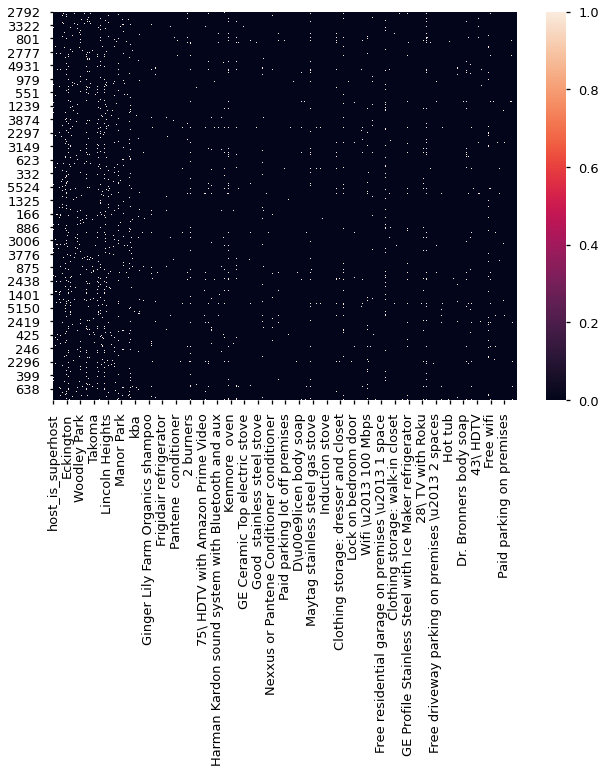

In [92]:
## Heatmap to visualize presence/absence of outliers
idx_train = (np.abs(X_train_tf_df) >= 3)
sns.heatmap(idx_train)

In [93]:
## Looking at the min/max values to ID extreme z-scores

X_train_tf_df.describe().loc[['min','50%', 'max']]

,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,bedrooms,beds,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,instant_bookable,num_bathrooms,Sheridan,Brentwood,Cardozo/Shaw,West End,Randle Highlands,Wesley Heights,Cathedral Heights,Chinatown,Kalorama Heights,Eckington,Benning,Langdon,Spring Valley,Columbia Heights,Fairfax Village,Capitol View,Mount Vernon Square,Barry Farm,Shepherd Park,Congress Heights,Tenleytown,Friendship Heights,Grant Park,Fairlawn,Woodridge,Queens Chapel,Truxton Circle,Douglas,Brightwood,GWU,Shaw,Southwest Employment Area,Glover Park,Woodley Park,Connecticut Avenue/K Street,Gateway,Foxhall Village,Michigan Park,Dupont Park,Naylor Gardens,Hawthorne,Twining,McLean Gardens,Stanton Park,Mt. Pleasant,Buena Vista,Georgetown,North Portal Estates,Mayfair,Kenilworth,Burleith/Hillandale,Fort Dupont,Shipley Terrace,Southwest/Waterfront,Cleveland Park,North Michigan Park,Trinidad,Takoma,Eastland Gardens,Lanier Heights,Van Ness,River Terrace,Navy Yard,Pleasant Hill,Park View,Downtown,Kingman Park,Marshall Heights,Mahaning Heights,Lincoln Park,Burrville,Woodland-Normanstone Terrace,Washington Highlands,Carver Langston,Fort Lincoln,Foxhall Crescent,Pleasant Plains,Ivy City,Foggy Bottom,North Capitol Street,American University Park,Lincoln Heights,Hillbrook,Le Droit Park,Summit Park,Fort Totten,Arboretum,Near Southeast,Massachusetts Avenue Heights,Fairmont Heights,Deanwood,Penn Branch,Brookland,Dupont Circle,Bellevue,Greenway,Historic Anacostia,Chevy Chase,Howard University,Benning Heights,Knox Hill,Bloomingdale,Buzzard Point,Capitol Hill,Hillcrest,Manor Park,Woodland/Fort Stanton,Petworth,Palisades,Crestwood,Fort Davis Park,Forest Hills,Garfield Heights,Union Station,Barnaby Woods,Fort McNair,North Cleveland Park,Penn Quarters,Georgetown Reservoir,Edgewood,Adams Morgan,Brightwood Park,Logan Circle,Lamont Riggs,Colonial Village,University Heights,facebook,jumio,manual_online,kba,identity_manual,reviews,sent_id,work_email,government_id,google,offline_government_id,manual_offline,weibo,selfie,phone,43\ HDTV with Netflix,40\ HDTV with Roku,and table,varies shampoo,Game console,Maytag refrigerator,Paid parking off premises,32\ HDTV with Amazon Prime Video,Whirlpool stainless steel stove,TV with standard cable,A good one refrigerator,24\ HDTV,Ginger Lily Farm Organics shampoo,Hair dryer,MayTag refrigerator,Wifi \u2013 5 Mbps,Security cameras on property,High chair,wardrobe,Clothing storage: dresser,HDTV with HBO Max,various body soap,HEAD & SHOULDERS conditioner,Papaya shampoo,Wifi,Bedroom comforts,Stainless steel induction stove,KitchenAid stainless steel electric stove,HDTV with Apple TV,Children\u2019s books and toys for ages 5-10 years old and 10+ years old,Children\u2019s books and toys for ages 0-2 years old and 2-5 years old,Wifi \u2013 25 Mbps,Free carport on premises \u2013 1 space,Paid parking on premises \u2013 2 spaces,Hot water,42\ HDTV with premium cable,Frigidair refrigerator,55\ HDTV with Amazon Prime Video,Whirlpool refrigerator,55\ HDTV with Roku,small samples shampoo,Fire extinguisher,50\ HDTV with Apple TV,Panasonic Surround Sound Home Theater sound system,Baby bath,Gas stove,Clothing storage: wardrobe and dresser,Children\u2019s dinnerware,Smoke alarm,Kirkland Body Wash or Ivory/Dove soap bar body soap,Board games,Lanvin Orange Ambre & Beekman 1802 shampoo,Ginger Lily Farm Organics conditioner,Kitchen Aid refrigerator,Lg oven,Wifi \u2013 940 Mbps,Waterfront,Dove conditioner,Portable air conditioning,Free carport on premises,Pantene conditioner,Aussie conditioner,Radiant heating,Stainless steel oven,Pool table,Wifi \u2013 125 Mbps,Game console: PS4,Dove and Trader Joes Products body soap,Mini-fridge with a VERY small freezer space. refrigerator,Table corner guards,Gym in building,Organic 365,Dedicated workspace: desk,Wifi \u2013 75 Mbps,Kirkland conditioner,Countertop oven oven,Shower gel,Free parking garag

In [94]:
X_train_tf_df.describe().loc[['min','50%', 'max']].max()

host_is_superhost                           1.41
host_listings_count                         7.99
host_total_listings_count                   7.99
host_has_profile_pic                        0.04
host_identity_verified                      0.47
                                            ... 
Portable speaker  Bluetooth sound system   63.80
room_type_entire_home                       1.00
room_type_hotel_room                        1.00
room_type_private_room                      1.00
room_type_shared_room                       1.00
Length: 815, dtype: float64

host_is_superhost                           1.41
host_listings_count                         7.99
host_total_listings_count                   7.99
host_has_profile_pic                        0.04
host_identity_verified                      0.47
                                            ... 
Portable speaker  Bluetooth sound system   63.80
room_type_entire_home                       1.00
room_type_hotel_room                        1.00
room_type_private_room                      1.00
room_type_shared_room                       1.00
Length: 815, dtype: float64

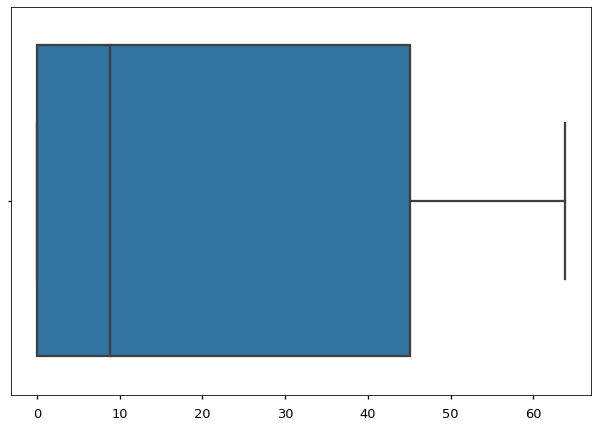

In [95]:
## Visualizing max values for each feature

display(X_train_tf_df.describe().loc[['min','50%', 'max']].max())

sns.boxplot(x=X_train_tf_df.describe().loc[['min','50%', 'max']].max());

host_is_superhost                           -0.71
host_listings_count                         -0.21
host_total_listings_count                   -0.21
host_has_profile_pic                       -28.52
host_identity_verified                      -2.11
                                            ...  
Portable speaker  Bluetooth sound system    -0.02
room_type_entire_home                        0.00
room_type_hotel_room                         0.00
room_type_private_room                       0.00
room_type_shared_room                        0.00
Length: 815, dtype: float64

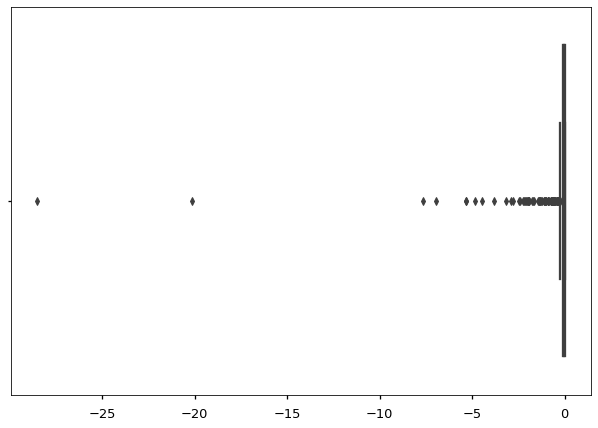

In [96]:
## Visualizing min values for each feature

display(X_train_tf_df.describe().loc[['min','50%', 'max']].min())

sns.boxplot(x=X_train_tf_df.describe().loc[['min','50%', 'max']].min());

# Baseline Model


|-------------------------------- Classification Metrics -----------------------------------|

Training accuracy score: 0.53
Testing accuracy score: 0.53
	- The scores are the same size.


Training data Log Loss: 16.31
Testing data log loss: 16.27


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.38      0.38      0.38      1548
           1       0.62      0.62      0.62      2523

    accuracy                           0.53      4071
   macro avg       0.50      0.50      0.50      4071
weighted avg       0.53      0.53      0.53      4071



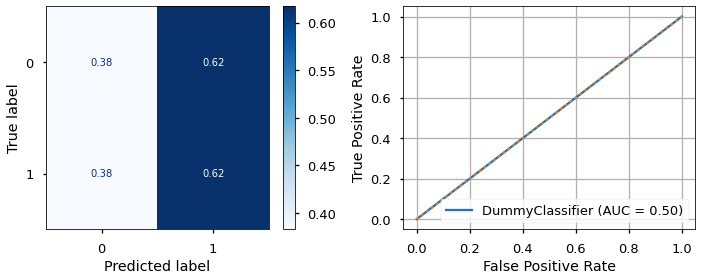



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.38      0.39      0.38       664
           1       0.62      0.62      0.62      1081

    accuracy                           0.53      1745
   macro avg       0.50      0.50      0.50      1745
weighted avg       0.53      0.53      0.53      1745



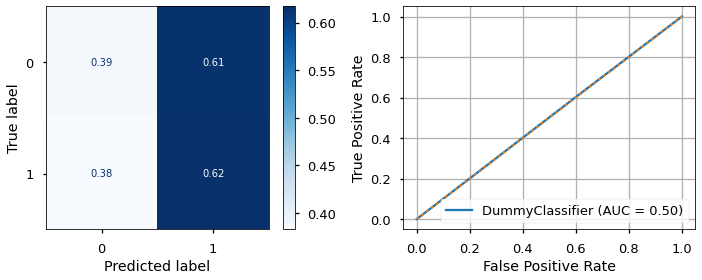

In [97]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)

base.fit(X_train_tf_df, y_train)

cf.evaluate_classification(base,X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test, 
                           metric = 'accuracy')

In [98]:
# ## Generating scores for later comparisons

# def model_scores(model, X_train, y_train, X_test, y_test):

#     y_hat_train = base.predict(X_train)
#     prob_train = base.predict_proba(X_train)

#     y_hat_test = base.predict(X_test)
#     prob_test = base.predict_proba(X_test)

#     base_train_ll = metrics.log_loss(y_train, prob_train).round(2)
#     base_test_ll = metrics.log_loss(y_test, prob_test).round(2)

#     base_train_score = base.score(X_train, y_train).round(2)
#     base_test_score = base.score(X_test,y_test).round(2)


#     return base_train_score, base_test_score, base_train_ll, base_test_ll

In [99]:
base_train_score, base_test_score, base_train_ll, base_test_ll = \
cf.model_scores(base, X_train_tf_df, y_train, X_test_tf_df, y_test)

base_train_score, base_test_score, base_train_ll, base_test_ll

(0.53, 0.53, 16.31, 16.27)

---

**Interpretation**

> The baseline model is designed to be a poor-performer: the results are intended to be be close to .5 for most metrics, indicating the model is not performing better than simply guessing one result or the other.
>
> I use this model as a comparison point to judge the performance of my other models.

---

#  Logistic Regression Model


|-------------------------------- Classification Metrics -----------------------------------|

Training accuracy score: 0.71
Testing accuracy score: 0.64
	- The training score is larger by 0.07 points.


Training data Log Loss: 0.55
Testing data log loss: 0.65


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.59      0.77      0.67      1548
           1       0.82      0.67      0.74      2523

    accuracy                           0.71      4071
   macro avg       0.71      0.72      0.70      4071
weighted avg       0.74      0.71      0.71      4071



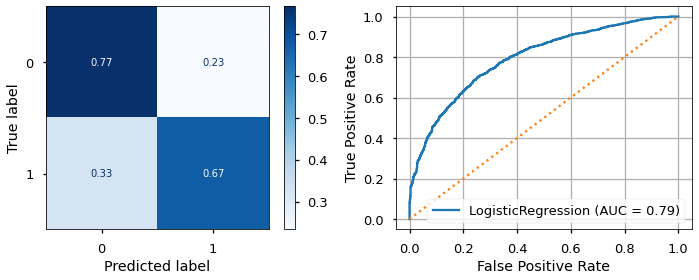



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.52      0.67      0.58       664
           1       0.75      0.62      0.68      1081

    accuracy                           0.64      1745
   macro avg       0.63      0.64      0.63      1745
weighted avg       0.66      0.64      0.64      1745



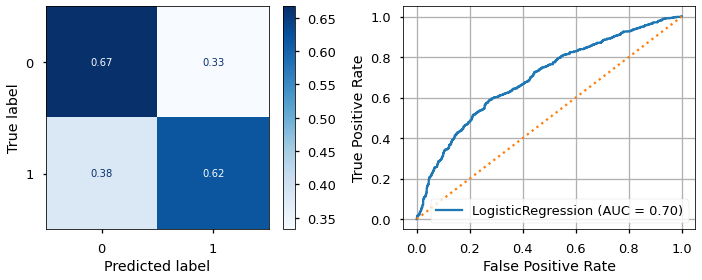

In [100]:
## Running logistic regression model to determine performance

clf = LogisticRegression(tol = 1e-3, C = 10, penalty = "l1", solver = 'saga', 
                         max_iter=500, class_weight='balanced', n_jobs=-1,
                         random_state = 42)

clf.fit(X_train_tf_df, y_train)

cf.evaluate_classification(clf, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'accuracy')

---

**Interpretation**

> Log loss increased by .12/.08 and AUC decreased by .05/.04 for training/test sets, respectively.
>
> I will test a different model type to see if I can get better scores with different modeling methods.

---

# KNN Model

In [101]:
# knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

In [102]:
# knn.fit(X_train_tf_df, y_train)

# cf.evaluate_classification(knn, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'accuracy', normalize=None)

# Decision Tree Model

In [103]:
# dtc = DecisionTreeClassifier(class_weight = 'balanced')

In [104]:
# dtc.fit(X_train_tf_df, y_train)

# cf.evaluate_classification(dtc, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'accuracy', normalize=None)

In [105]:
# dtc.get_depth()

# RandomForestClassifier

In [106]:
rfc = RandomForestClassifier(bootstrap = False,max_features= 'sqrt', class_weight = 'balanced',
                            n_jobs=-1, max_depth = 15, min_samples_leaf = 3,
                            min_samples_split = 4, random_state=42)

In [107]:
rfc.fit(X_train_tf_df, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=15,
                       max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=4, n_jobs=-1, random_state=42)


|-------------------------------- Classification Metrics -----------------------------------|

Training accuracy score: 0.9
Testing accuracy score: 0.68
	- The training score is larger by 0.22 points.


Training data Log Loss: 0.46
Testing data log loss: 0.61


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1548
           1       0.95      0.88      0.91      2523

    accuracy                           0.90      4071
   macro avg       0.89      0.90      0.89      4071
weighted avg       0.90      0.90      0.90      4071



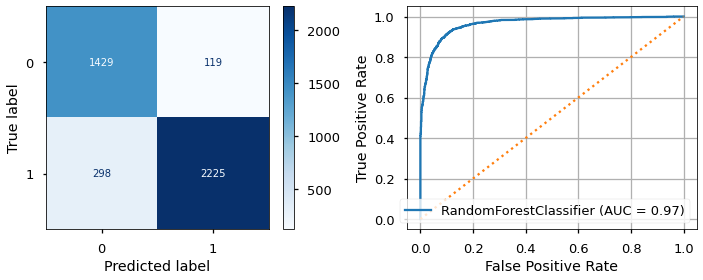



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       664
           1       0.76      0.72      0.74      1081

    accuracy                           0.68      1745
   macro avg       0.67      0.67      0.67      1745
weighted avg       0.69      0.68      0.69      1745



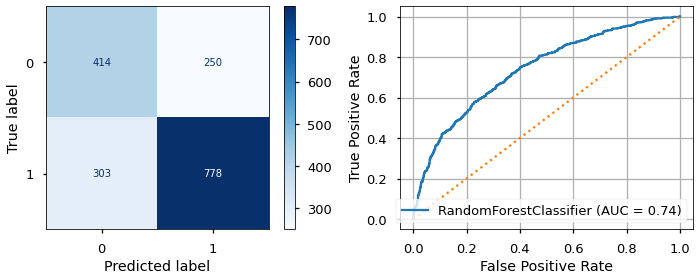

In [108]:
cf.evaluate_classification(rfc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'accuracy', normalize=None)

## Results

---

> **Comparing with Logistic Regression Model**
>
> The Random Forest classification model shows a higher degree of over-fitting; this is to be expected for tree-style models.
>
> This model shows slight performance increases as well. The log-loss decreased slightly as well, and the main two metrics of macro recall and accuracy both increased slightly.
>
> I will use this model as my best-performing model and will use its feature importances for my recommendations.

---

## Visualizing Feature Importances

---

> Now that I have the feature importances from my model, I interpret the results via visualizing the most important features and the target feature.

---

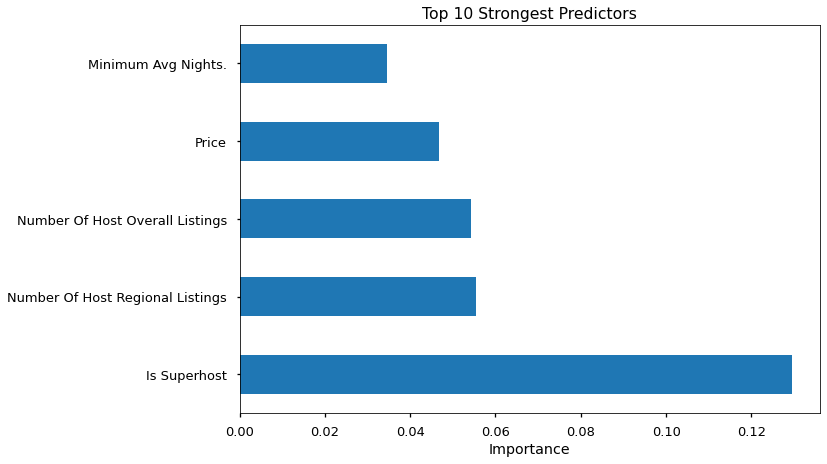

In [109]:
cf.plot_importances(rfc, X_test_tf_df, count=5)

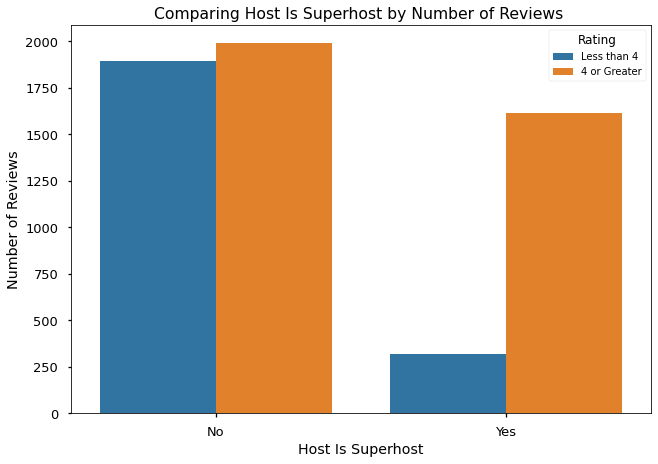

In [110]:
## Visualizing top 
cf.plot_comparison_count('host_is_superhost',dataframe = df)

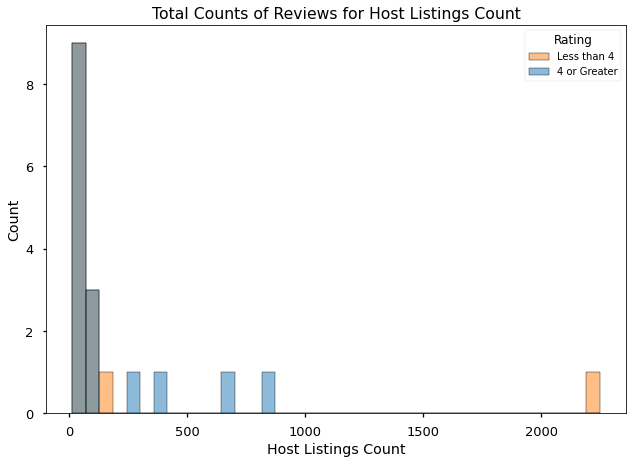

In [149]:
cf.plot_comparison_hist('host_listings_count',df, target='review_scores_rating', bins = 5)

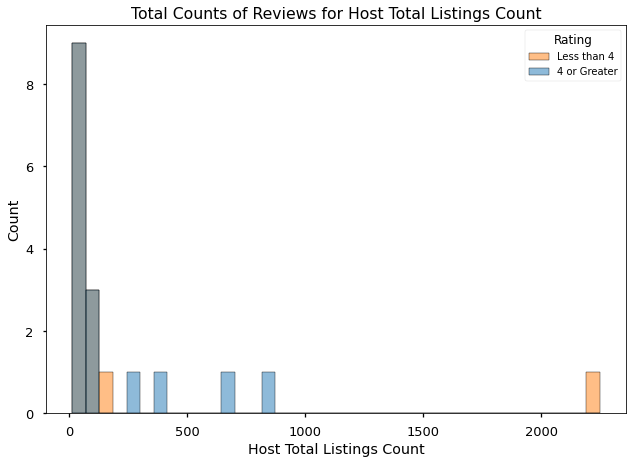

In [154]:
cf.plot_comparison_hist('host_total_listings_count',df, target='review_scores_rating', bins = 5)

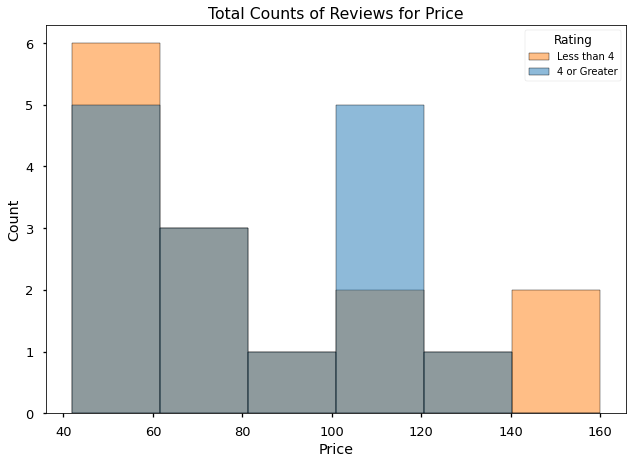

In [155]:
cf.plot_comparison_hist('price',df, target='review_scores_rating', bins = 5)

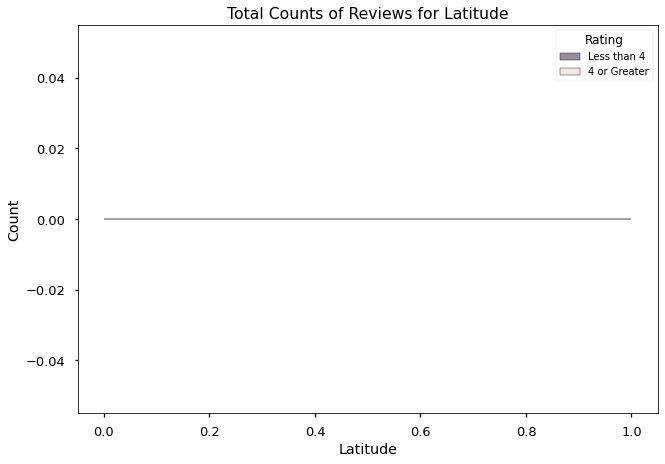

In [114]:
cf.plot_comparison_hist('latitude',df, target='review_scores_rating', bins = 5)

# AdaBoostClassifier

In [115]:
abc = AdaBoostClassifier(n_estimators=100, random_state=42)


|-------------------------------- Classification Metrics -----------------------------------|

Training accuracy score: 0.74
Testing accuracy score: 0.69
	- The training score is larger by 0.05 points.


Training data Log Loss: 0.69
Testing data log loss: 0.69


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.68      0.57      0.62      1548
           1       0.76      0.84      0.80      2523

    accuracy                           0.74      4071
   macro avg       0.72      0.70      0.71      4071
weighted avg       0.73      0.74      0.73      4071



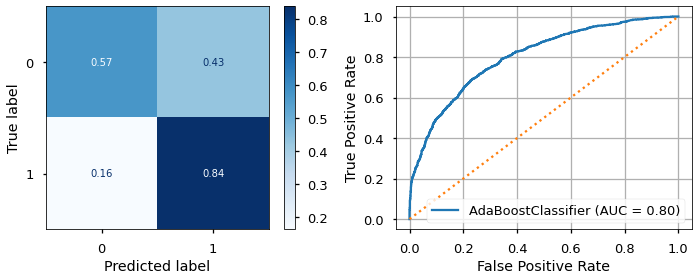



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.60      0.52      0.56       664
           1       0.73      0.79      0.76      1081

    accuracy                           0.69      1745
   macro avg       0.67      0.65      0.66      1745
weighted avg       0.68      0.69      0.68      1745



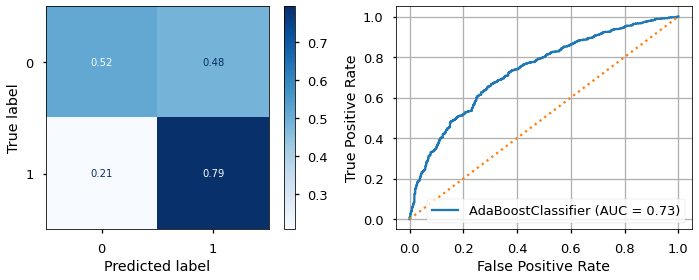

In [116]:
abc.fit(X_train_tf_df, y_train)

cf.evaluate_classification(abc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'accuracy')

# Gradient Boosting

In [117]:
# gbc = GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42)

In [118]:
# gbc.fit(X_train_tf_df, y_train)

# cf.evaluate_classification(gbc, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'accuracy')

# GridSearchCV: LogisticRegression

In [119]:
# import warnings
# warnings.filterwarnings('ignore')

In [120]:
# lr_params = {
#  'C': [.001, .01, .1, 1, 10, 100, 1000],
#     'penalty':['l1', 'l2', 'elasticnet', 'none'],
#     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'max_iter':[100, 200, 300, 400]}

In [121]:
# gscv = GridSearchCV(LogisticRegression(class_weight='balanced'), lr_params, scoring = 'balanced_accuracy', cv=3,
#                     n_jobs = -1)
# gscv

In [122]:
# gscv.fit(X_train_tf_df, y_train)

In [123]:
# logreg_params = gscv.best_params_

# logreg_params

## Best LogReg params

logreg_params = `{'C': 0.1,
  'class_weight': 'balanced',
  'max_iter': 100,
  'penalty': 'l1',
  'solver': 'saga'}`

In [124]:
# gscv.best_estimator_

In [125]:
# cf.evaluate_classification(gscv.best_estimator_, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced accuracy')

# GSCV: RandomForestClassifier

In [126]:
# rfc_params = {
#     'n_estimators':[100, 125, 150,],
#     'max_depth': [10,20,30,40],
#     'min_samples_split': [2,3,4],
#     'min_samples_leaf': [1,2,3]
# }

In [127]:
# rfc = RandomForestClassifier(class_weight = 'balanced',
#                             n_jobs=-1, random_state=42)

In [128]:
# rfgs = GridSearchCV(rfc, rfc_params, scoring = 'balanced_accuracy', cv=3,
#                     n_jobs = -1)
# rfgs

In [129]:
# rfgs.fit(X_train_tf_df, y_train)

In [130]:
# rfc_params = rfgs.best_params_

# rfc_params

In [131]:
# rfgs.best_score_

In [132]:
# rfc_new = rfgs.best_estimator_

In [133]:
# cf.evaluate_classification(rfc_new, X_train_tf_df, y_train, X_test_tf_df, 
#                            y_test, 'recall (macro)')

# GSCV: AdaBoost

In [134]:
# abc_params = {'n_estimators': [10,20, 30],
# 'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

# # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# abc = AdaBoostClassifier(DecisionTreeClassifier(),random_state=42)

# abgs = GridSearchCV(estimator=abc, param_grid=abc_params, n_jobs=-1,
#                            cv=3, scoring='balanced_accuracy', verbose=2)


In [135]:
# abgs.fit(X_train_tf_df, y_train)

In [136]:
# abc_best_params = abgs.best_params_

# abc_best_params

In [137]:
# abgs.best_score_

In [138]:
# abc_new = abgs.best_estimator_

In [139]:
# cf.evaluate_classification(abc_new, X_train_tf_df, y_train, X_test_tf_df, 
#                            y_test, 'recall (macro)')

# XGBoost

In [140]:
# from xgboost import XGBClassifier

In [141]:
# xbgc = XGBClassifier()

In [142]:
# xbgc.fit(X = X_train_tf_df, y=y_train)

In [143]:
# xbgc.predict(X_test_tf_df)

In [144]:
# cf.evaluate_classification(xbgc,X_train_tf_df, y_train, X_test_tf_df, y_test, metric= 'accuracy')

In [145]:
# xgbc_names = xbgc.get_booster().feature_names
# # xgbc_names

In [146]:
# xgbc_importances = xbgc.feature_importances_
# # xgbc_importances

In [147]:
# xgbc_results = pd.Series(data = xgbc_importances, index = xgbc_names)
# xgbc_results

In [148]:
# xgbc_results.sort_values(ascending = False)